## Combined Analysis for nyc crime and nyc airbnb households:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm 
import warnings
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from  sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import plotly.express as px

from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

### 1. Merge final_crime and nyc-Airbnb-2023

Annotation: In Data directory, NYC-crime.csv and NYC-Airbnb-2023.csv is our raw data. After cleaning, manipulating and compressing, we finally obtained airbnb.csv and final_crime.csv.

In [2]:
airbnb = pd.read_csv('./Data/airbnb.csv')
crime = pd.read_csv('./Data/final_crime.csv')

In [3]:
airbnb_crime = pd.merge(airbnb, crime, on='neighbourhood_cd', how='left')

In [4]:
airbnb_crime.head()

id neighbourhood_group  latitude  longitude        room_type  price  \
0   5121            Brooklyn  40.68535  -73.95512     Private room     60   
1   5203           Manhattan  40.80380  -73.96751     Private room     75   
2   5136            Brooklyn  40.66265  -73.99454  Entire home/apt    275   
3  29628            Brooklyn  40.68292  -73.96381     Private room     93   
4   5586           Manhattan  40.76076  -73.96156  Entire home/apt    295   

   minimum_nights  number_of_reviews  reviews_per_month  \
0              30                 50               0.30   
1               2                118               0.72   
2              60                  3               0.03   
3               3                350               2.25   
4               4                 45               0.27   

   calculated_host_listings_count  availability_365  neighbourhood_cd  \
0                               2               365             108.0   
1                               1                 0             126.0   
2                               1               181             109.0   
3                               1               145             107.0   
4                               1                 1             142.0   

   annual_crime_rate  annual_felony_rate  annual_misdemeanor_rate  \
0        8007.500000         2527.071429              4822.714286   
1         464.285714          104.071429               326.000000   
2        1204.000000          395.857143               705.142857   
3        1580.500000          539.500000               917.571429   
4         190.285714           26.428571               157.714286   

   annual_violation_rate  annual_infraction_rate  \
0             628.000000               29.714286   
1              32.714286                1.500000   
2              94.214286                8.785714   
3             116.142857                7.285714   
4               3.428571                2.714286   

                        dominant_ofns dominant_perp_race  
0         marijuana, possession 4 & 5              black  
1         marijuana, possession 4 & 5              black  
2                           assault 3     white hispanic  
3  controlled substance, possession 7              black  
4         intoxicated driving,alcohol              white

### 2. EDA

In [5]:
airbnb_crime.nunique()

id                                35707
neighbourhood_group                   5
latitude                          20509
longitude                         17660
room_type                             4
price                               899
minimum_nights                      120
number_of_reviews                   447
reviews_per_month                   812
calculated_host_listings_count       63
availability_365                    366
neighbourhood_cd                    347
annual_crime_rate                   340
annual_felony_rate                  319
annual_misdemeanor_rate             340
annual_violation_rate               227
annual_infraction_rate              114
dominant_ofns                        16
dominant_perp_race                    4
dtype: int64

In [6]:
airbnb_crime.isnull().sum()

id                                0
neighbourhood_group               0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
neighbourhood_cd                  0
annual_crime_rate                 0
annual_felony_rate                0
annual_misdemeanor_rate           0
annual_violation_rate             0
annual_infraction_rate            0
dominant_ofns                     0
dominant_perp_race                0
dtype: int64

In [7]:
airbnb_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35707 entries, 0 to 35706
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              35707 non-null  int64  
 1   neighbourhood_group             35707 non-null  object 
 2   latitude                        35707 non-null  float64
 3   longitude                       35707 non-null  float64
 4   room_type                       35707 non-null  object 
 5   price                           35707 non-null  int64  
 6   minimum_nights                  35707 non-null  int64  
 7   number_of_reviews               35707 non-null  int64  
 8   reviews_per_month               35707 non-null  float64
 9   calculated_host_listings_count  35707 non-null  int64  
 10  availability_365                35707 non-null  int64  
 11  neighbourhood_cd                35707 non-null  float64
 12  annual_crime_rate               

The cleaned dataset is mostly int, object and float type.

In [8]:
outliers_price = airbnb_crime[airbnb_crime['price'] < 500]

Since the outliers may impact the accuracy of our analysis, we need to remove them. Therefore, we use the range below 500 to filter the outliers of price.

Histograms Visualization for "price" and "annual_crime_rate"

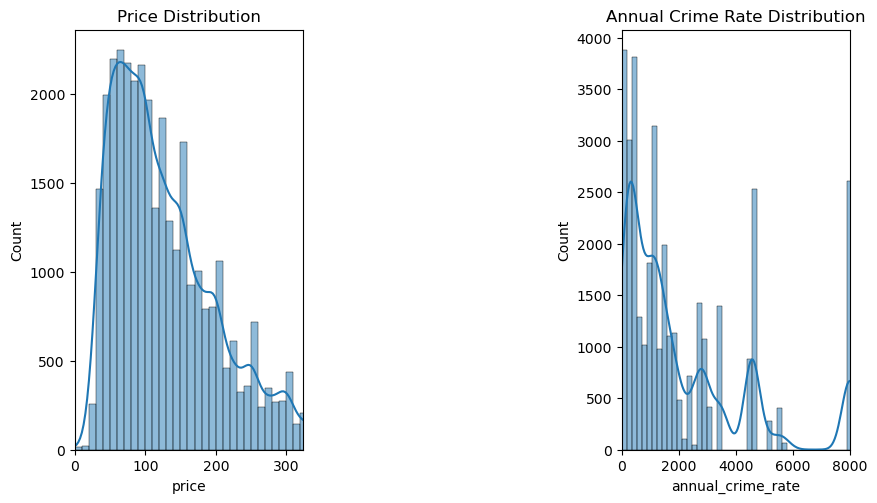

In [9]:
plt.figure(figsize=(10, 12))

plt.subplot(2, 3, 1)
sns.histplot(outliers_price['price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.xlim(0, outliers_price['price'].quantile(0.95))

plt.subplot(2, 3, 3)
sns.histplot(airbnb_crime['annual_crime_rate'], bins=50, kde=True)
plt.title('Annual Crime Rate Distribution')
plt.xlim(0, airbnb_crime['annual_crime_rate'].quantile(0.95))

plt.show()

Outliers: By limiting the x-axis to range from 0 to the 95th percentile, we can focus on the most common range and exclude extreme outliers.

Price Distribution:
1. The price range of airbnb is mostly centralized to 50-100 among the whole dataset.
2. The price of airbnb is right skewed.
3. The dataset is normally distributed.

Number of Reviews Distribution:
1. Number of Reviews has a long tail distribution.

Annual Crime Rate Distribution:
1. The annual crime rate is right skewed.
2. The centralized annual crime rate in NYC is among 500-1000.
3. The highest crime cases have 2600 per year.

Boxplot Visualization for "price", "minimum_nights" and "availability_365"

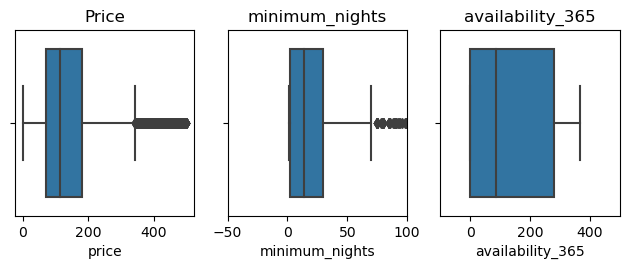

In [10]:
# plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 4)
sns.boxplot(x=outliers_price['price'])
plt.title('Price')

plt.subplot(2, 3, 5)
sns.boxplot(x=airbnb_crime['minimum_nights'])
plt.title('minimum_nights')
plt.xlim(-50, 100)

plt.subplot(2, 3, 6)
sns.boxplot(x=airbnb_crime['availability_365'])
plt.title('availability_365')
plt.xlim(-100, 500)

plt.tight_layout()
plt.show()

1. Price: The house price in the box plot is around 110, which is mostly affordable for people.
2. Minimum_nights: The minimum nights in the box plot is around 10-20 days, which is reasonable for people to live in in NYC for cheap price.
3. Availability_365: The annual availability of a house in NYC is around 100 rooms left.
4. There are some outliers in the box plot, which may impact the accuracy of our analysis.

Boxplot and Hexbin isualization for "price" and "annual_crime_rate"

/var/folders/pr/r0bhz2p568x48xk2vr6zysbw0000gn/T/ipykernel_1325/2447469372.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_price['crime_rate_category'] = crime_bins


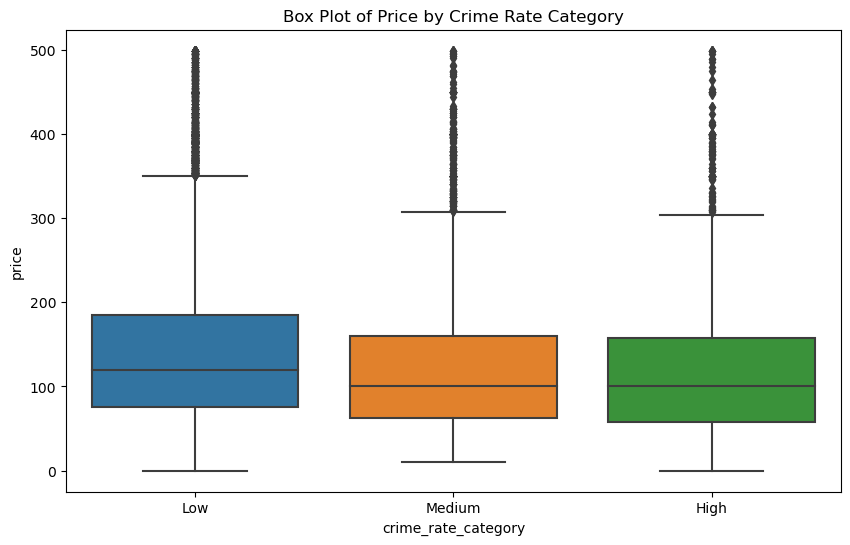

In [11]:
# Binning the crime rate
crime_bins = pd.cut(outliers_price['annual_crime_rate'], bins=3, labels=['Low', 'Medium', 'High'])
outliers_price['crime_rate_category'] = crime_bins

plt.figure(figsize=(10, 6))
sns.boxplot(data=outliers_price, x='crime_rate_category', y='price')
plt.title('Box Plot of Price by Crime Rate Category')
plt.show()

<Figure size 1000x600 with 0 Axes>

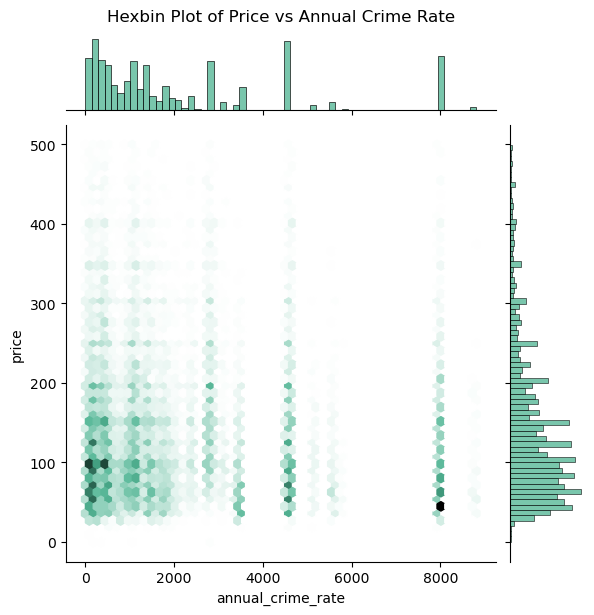

In [12]:
plt.figure(figsize=(10, 6))
sns.jointplot(data=outliers_price, x='annual_crime_rate', y='price', kind="hex", color="#4CB391")
plt.title('Hexbin Plot of Price vs Annual Crime Rate', pad=75)
plt.show()

Price vs Annual Crime Rate:
1. The price of airbnb and the annual crime rate shows negative relationship between each other. The lower the price of airbnb, the higher chance of the annual crime rate happens. However, there is no direct relationship as the boxplot shows that the median of crime rate happens in price around 100, indicating that it may have some other critical factors that impact the crime rate of airbnb.

Room type distribution and Dominant Offense Distribution

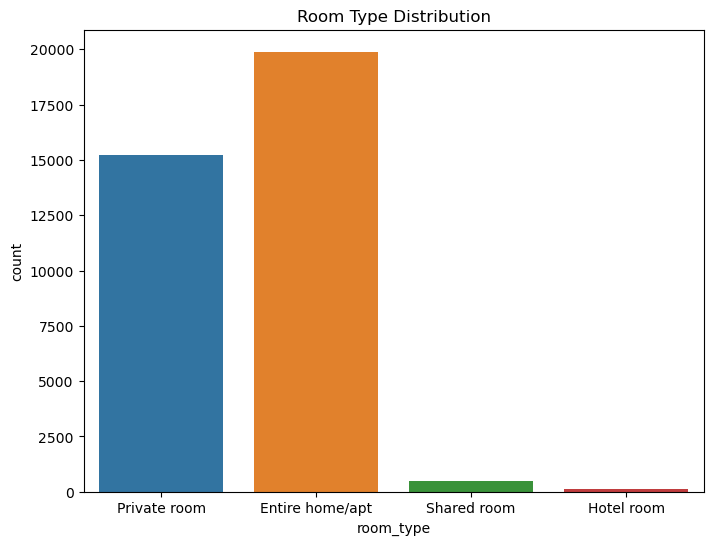

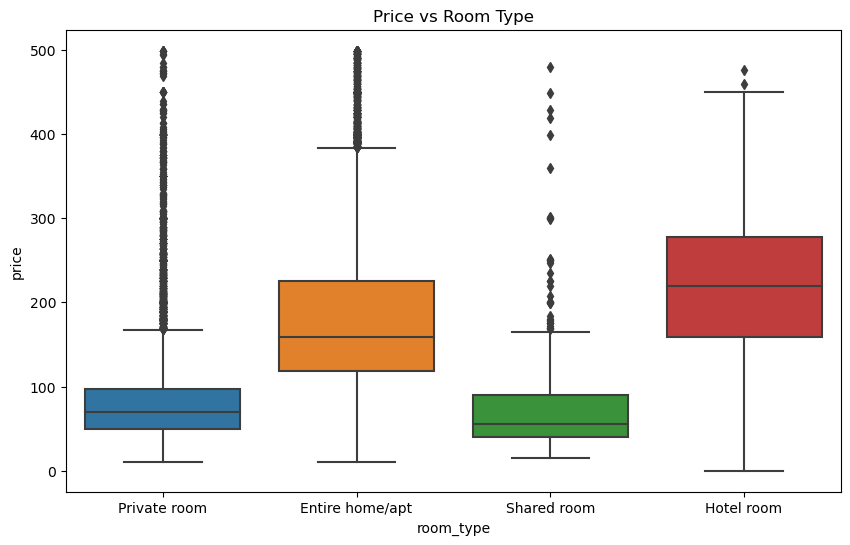

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(data=airbnb_crime, x='room_type')
plt.title('Room Type Distribution')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=outliers_price, x='room_type', y='price')
plt.title('Price vs Room Type')
plt.show()

Room Type Distribution:
1. The room type of airbnb is mostly entire home/apt, which is around 50% of the whole dataset.
2. The shared room and hotel room are the least room type in the dataset.

Price vs Room Type:
1. The airbnb price of the hotel room has the median of 200, which is the highest among the whole dataset. However, the hotel room is the least room type in the dataset.
2. The airbnb price of the entire home/apt has the median of 150, which is the second highest among the whole dataset. However, the entire home/apt is the most room type in the dataset. It may be because people tend to live with their entire family to suppport the living expenses in NYC.

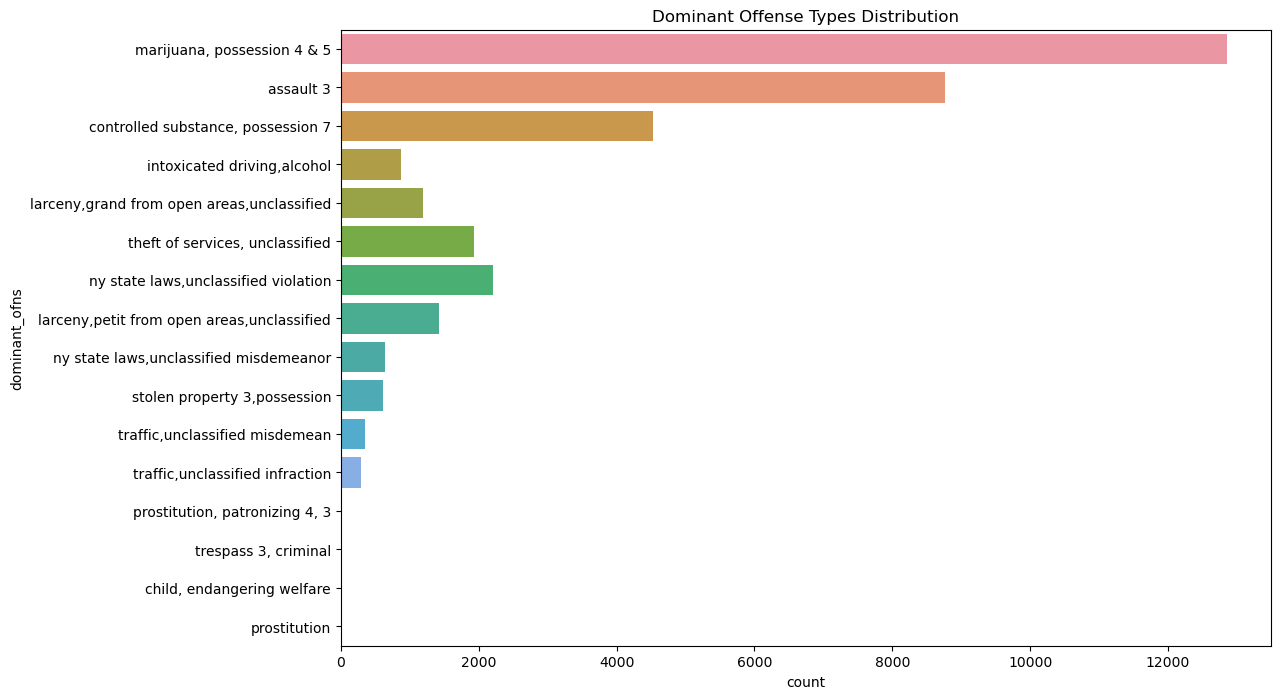

In [14]:
plt.figure(figsize=(12, 8))
sns.countplot(data=airbnb_crime, y='dominant_ofns')
plt.title('Dominant Offense Types Distribution')
plt.show()

Dominant Offense Distribution:
1. The marijuana possession is among the highest types of crime in NYC, along with the other 2 types of crime: assault and controlled substance.


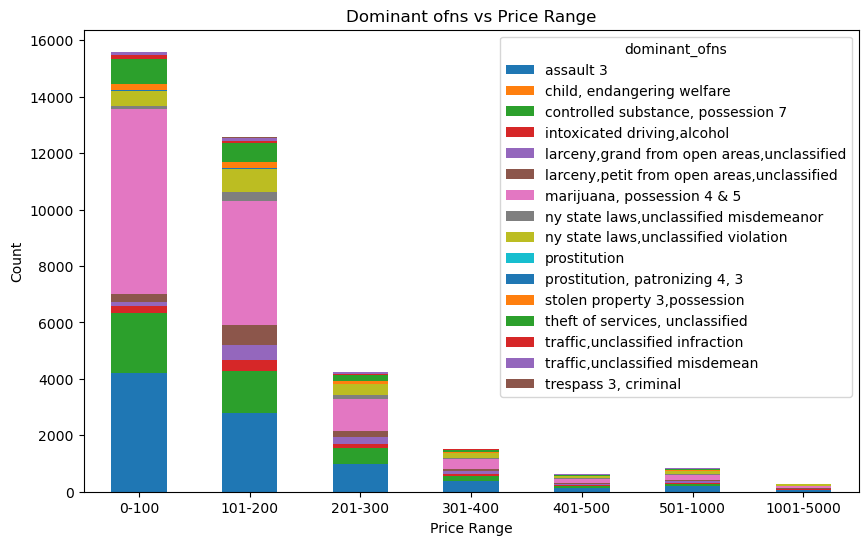

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

bins = [0, 100, 200, 300, 400, 500, 1000, 5000]
labels = ['0-100', '101-200', '201-300', '301-400', '401-500', '501-1000', '1001-5000']
airbnb_crime['price_category'] = pd.cut(airbnb_crime['price'], bins=bins, labels=labels)

pivot_data = airbnb_crime.groupby(['price_category', 'dominant_ofns']).size().unstack().fillna(0)

pivot_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Dominant ofns vs Price Range')
plt.xlabel('Price Range')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Dominant Offense vs Room Type:
1. While the price range is within 0-100, the scope of all the dominat offenses expands. It may be because the price is low, so the crime rate is high, following the crime of marijuana possession, assault and controlled substance.
2. Some potential influential factors may impact the price of airbnb, such as the theft of services, property damage and stolen. Importantly, the datset has nearly no data for these 3 types of crime in NYC.
2. There are some dominant offenses that are unclassfied in the dataset.

Heatmap Visualization for airbnb_crime

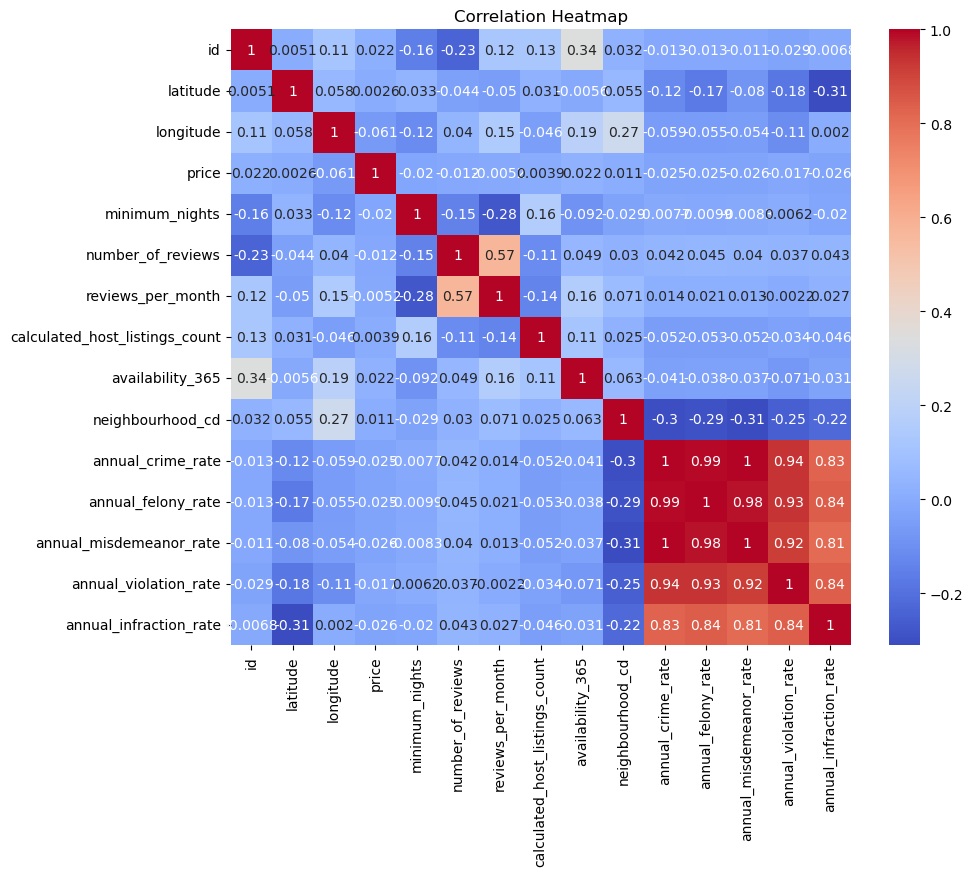

In [16]:
numeric = airbnb_crime.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Heatmap Visualization:
1. Geographic Coordinates: There is some level of positive correlation between 'latitude' and 'longitude', which could indicate a geographic pattern in the data where certain latitudes and longitudes are related (e.g., specific neighborhoods or areas).

2. Price Correlations: The 'price' variable shows a moderate positive correlation with 'calculated_host_listings_count' and 'availability_365', suggesting that listings with a higher price might also have a higher number of host listings and are available more days in a year.

3. Crime Rates: There seem to be strong positive correlations within the crime-related variables ('annual_crime_rate', 'annual_felony_rate', 'annual_misdemeanor_rate', 'annual_violation_rate', 'annual_infraction_rate'). This indicates that when any type of crime rate increases, the others tend to increase as well.

### 3. Correlation and Significance

#### 3.1 
- In order to better understand the significant influence of crime on airbnb house price, we first parse the airbnb_crime dataset by room_type, and we will investigate the price distribution by dominant crime category.

In [17]:
airbnb_crime['room_type'].replace({'Entire home/apt': 'Entire room'}, inplace=True)
airbnb_crime['room_type'].value_counts()    

Entire room     19891
Private room    15244
Shared room       465
Hotel room        107
Name: room_type, dtype: int64

In [18]:
remove_outlier = airbnb_crime[airbnb_crime['price'] < 500]

In [19]:
private_room = remove_outlier[remove_outlier['room_type'] == 'Private room']
entire_room = remove_outlier[remove_outlier['room_type'] == 'Entire room']
shared_room = remove_outlier[remove_outlier['room_type'] == 'Shared room']
hotel_room =  airbnb_crime[airbnb_crime['room_type'] == 'Hotel room']

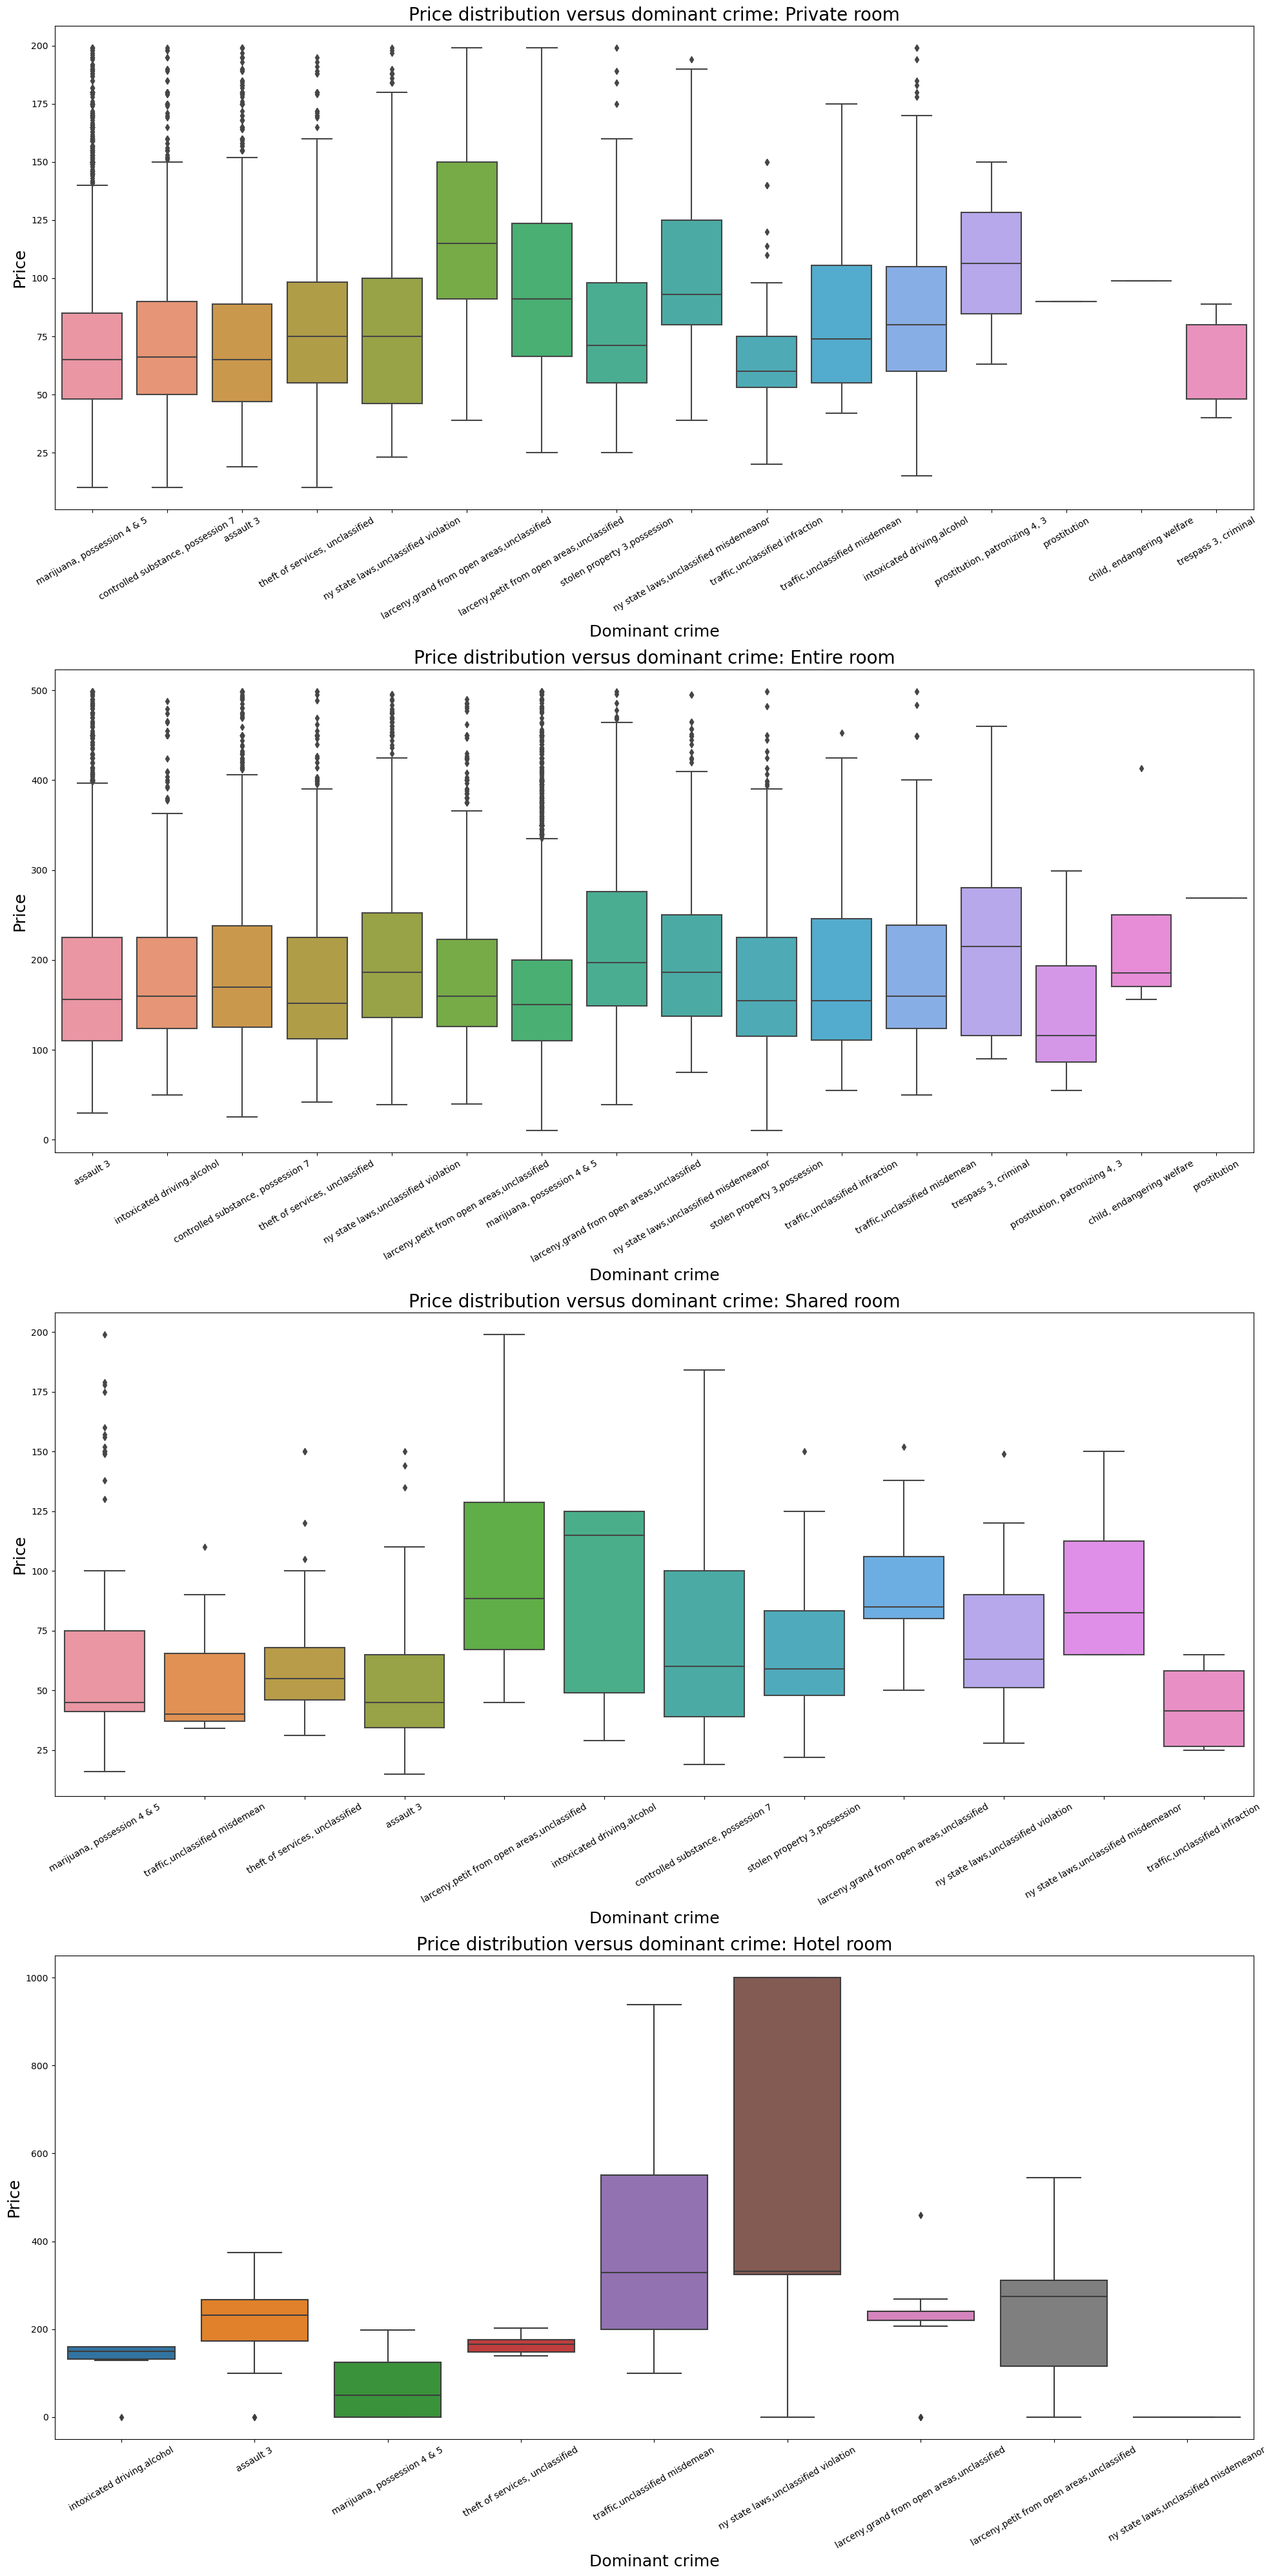

In [20]:
fig, axes = plt.subplots(4, 1, figsize=(20, 40))


sns.boxplot(x="dominant_ofns",y="price",data=private_room[private_room['price']<200], ax=axes[0])
axes[0].tick_params(axis='x', rotation=30)
axes[0].set_title('Price distribution versus dominant crime: Private room',fontsize=20)
axes[0].set_xlabel('Dominant crime', fontsize=18)
axes[0].set_ylabel('Price', fontsize=18)

sns.boxplot(x="dominant_ofns",y="price",data=entire_room[entire_room['price']<500], ax=axes[1])
axes[1].tick_params(axis='x', rotation=30)
axes[1].set_title('Price distribution versus dominant crime: Entire room',fontsize=20)
axes[1].set_xlabel('Dominant crime', fontsize=18)
axes[1].set_ylabel('Price', fontsize=18)

sns.boxplot(x="dominant_ofns",y="price",data=shared_room[shared_room['price']<200], ax=axes[2])
axes[2].tick_params(axis='x', rotation=30)
axes[2].set_title('Price distribution versus dominant crime: Shared room',fontsize=20)
axes[2].set_xlabel('Dominant crime', fontsize=18)
axes[2].set_ylabel('Price', fontsize=18)

sns.boxplot(x="dominant_ofns",y="price",data=hotel_room, ax=axes[3])
axes[3].tick_params(axis='x', rotation=30)
axes[3].set_title('Price distribution versus dominant crime: Hotel room',fontsize=20)
axes[3].set_xlabel('Dominant crime', fontsize=18)
axes[3].set_ylabel('Price', fontsize=18)


plt.tight_layout()
plt.show()

We can see that in each room_type category, the mean price of houses lying in neighbourhoods with certain dominant crime can vary greatly with others. Now, we are going to statistically find the pattern and proof out. Since the sample from hotel room and shared room are not large, we will only look into private rooms and entire room price.

- private_room

In [21]:
res2 = pairwise_tukeyhsd(private_room['price'], private_room['dominant_ofns'])
res2.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

- entire room

In [22]:
res2 = pairwise_tukeyhsd(entire_room['price'], entire_room['dominant_ofns'])
res2.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [23]:
res = smf.ols("Q('price') ~ Q('dominant_ofns') + Q('room_type') + Q('neighbourhood_group')",remove_outlier).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             Q('price')   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     841.0
Date:                Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:04:12   Log-Likelihood:            -1.9619e+05
No. Observations:               34448   AIC:                         3.924e+05
Df Residuals:                   34425   BIC:                         3.926e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

### 3.1 Conclusion: 
By tukey's hsd, 
We can see that in entire room and private room groups:
- The mean prices from larceny, ny state laws dominant areas tend to be significantly different from other crime categories dominant areas.
- The reason could be that since the price of these rooms are high, which means the owner or customers who choose these rooms could be richer. As a result, the house owners or customers are easier to be chosen as larceny target.

By ols regression, 
R-squared is relatively low, indicating that the model does not explain a large portion of the variance in the dependent variable, however:
- Prob (F-statistic) is quite low, suggesting that the model as a whole is statistically significant (i.e., at least one predictor variable has a non-zero coefficient).
- The p-value of larceny and ny state laws are less than 0.05, which also verifies a significant positive relationship with the room price compared with other dominant crime neighbourhood areas.

### 3.2

- We want to explore, whether additional features of annual crime rate can explain the price better.

In [24]:
res = smf.ols("Q('price') ~ Q('annual_felony_rate') + Q('room_type')\
              + Q('annual_misdemeanor_rate') + Q('annual_violation_rate') \
              + Q('annual_infraction_rate')",airbnb_crime[airbnb_crime['price']<500]).fit() 
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             Q('price')   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     2233.
Date:                Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:04:12   Log-Likelihood:            -1.9715e+05
No. Observations:               34448   AIC:                         3.943e+05
Df Residuals:                   34440   BIC:                         3.944e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### 4. Clustering and Validation

First we creat a heatmap to have an overview.

<Axes: >

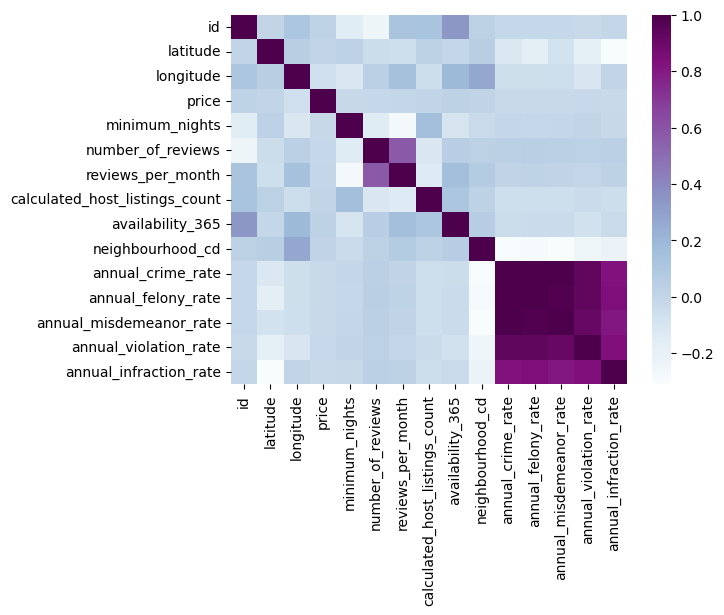

In [25]:
sns.heatmap(airbnb_crime.corr(numeric_only=True), cmap='BuPu')

Prepare for the pipeline of clustering.

In [26]:
for i in range(len(airbnb_crime.columns)):
    print(i, type(airbnb_crime.iloc[0,i]))

0 <class 'numpy.int64'>
1 <class 'str'>
2 <class 'numpy.float64'>
3 <class 'numpy.float64'>
4 <class 'str'>
5 <class 'numpy.int64'>
6 <class 'numpy.int64'>
7 <class 'numpy.int64'>
8 <class 'numpy.float64'>
9 <class 'numpy.int64'>
10 <class 'numpy.int64'>
11 <class 'numpy.float64'>
12 <class 'numpy.float64'>
13 <class 'numpy.float64'>
14 <class 'numpy.float64'>
15 <class 'numpy.float64'>
16 <class 'numpy.float64'>
17 <class 'str'>
18 <class 'str'>
19 <class 'str'>


In [27]:
airbnb_crime_X = airbnb_crime.drop(['id', 'price'], axis=1)
airbnb_crime_y = airbnb_crime[['id', 'price']]

In [28]:
num_attribs = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 
               'calculated_host_listings_count', 'availability_365', 'neighbourhood_cd', 
               'annual_crime_rate', 'annual_felony_rate', 'annual_misdemeanor_rate', 
               'annual_violation_rate', 'annual_infraction_rate',]
cat_attribs = ['neighbourhood_group', 'room_type', 'dominant_ofns', 'dominant_perp_race']

In [29]:
pipe = Pipeline(
    [
        ('scale', ColumnTransformer([
            ("num", StandardScaler(), num_attribs),
            ("cat", OneHotEncoder(), cat_attribs),
            ])
        ),
        ('pca', PCA(n_components=5, random_state=42)),
        ('kmeans', KMeans(n_clusters=2, init='k-means++', random_state=42)),
    ]
)
#ignore warnings that might be generated by the silhouette_score function
warnings.simplefilter(action='ignore', category=FutureWarning)

In [30]:
stored_y = {}

Run the pipeline and store the clustering result in `stored_y`.

For n_clusters = 2 The average silhouette_score is : 0.3877575019479541
For n_clusters = 3 The average silhouette_score is : 0.31112921517187647
For n_clusters = 4 The average silhouette_score is : 0.29180816648392166
For n_clusters = 5 The average silhouette_score is : 0.3078785718528418
For n_clusters = 6 The average silhouette_score is : 0.3133932095002381
For n_clusters = 7 The average silhouette_score is : 0.31820538101410917
For n_clusters = 8 The average silhouette_score is : 0.31309310143611085
For n_clusters = 9 The average silhouette_score is : 0.2974231188880438
For n_clusters = 10 The average silhouette_score is : 0.28841793420810347
For n_clusters = 11 The average silhouette_score is : 0.28438319865427336
For n_clusters = 12 The average silhouette_score is : 0.28794870010207657
For n_clusters = 13 The average silhouette_score is : 0.29577894438895574
For n_clusters = 14 The average silhouette_score is : 0.3036223370276616
For n_clusters = 15 The average silhouette_score is

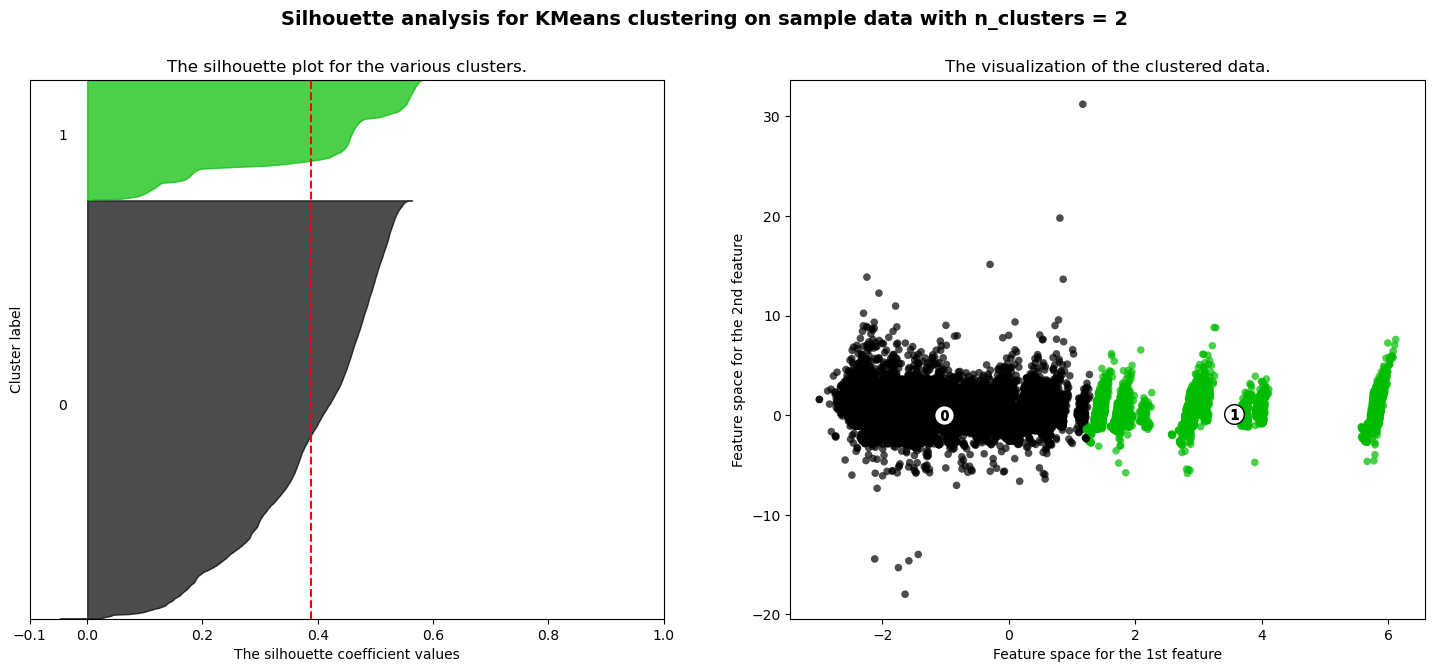

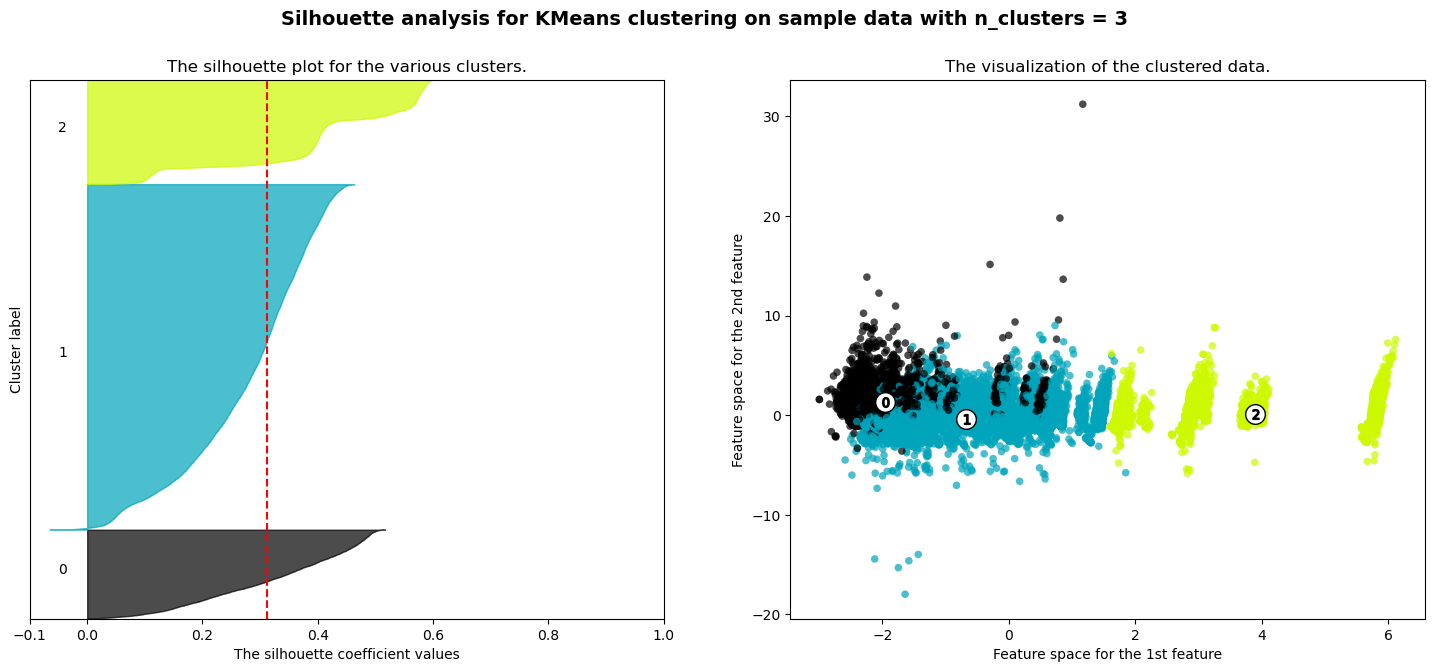

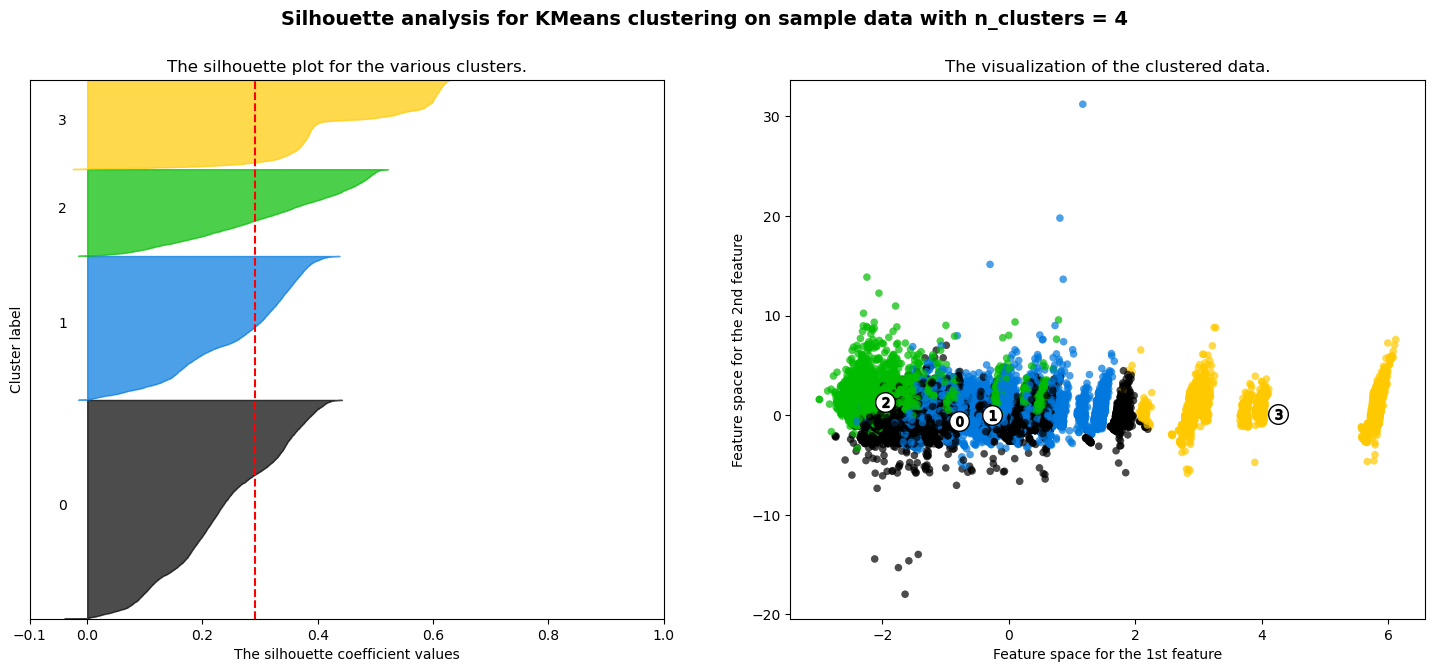

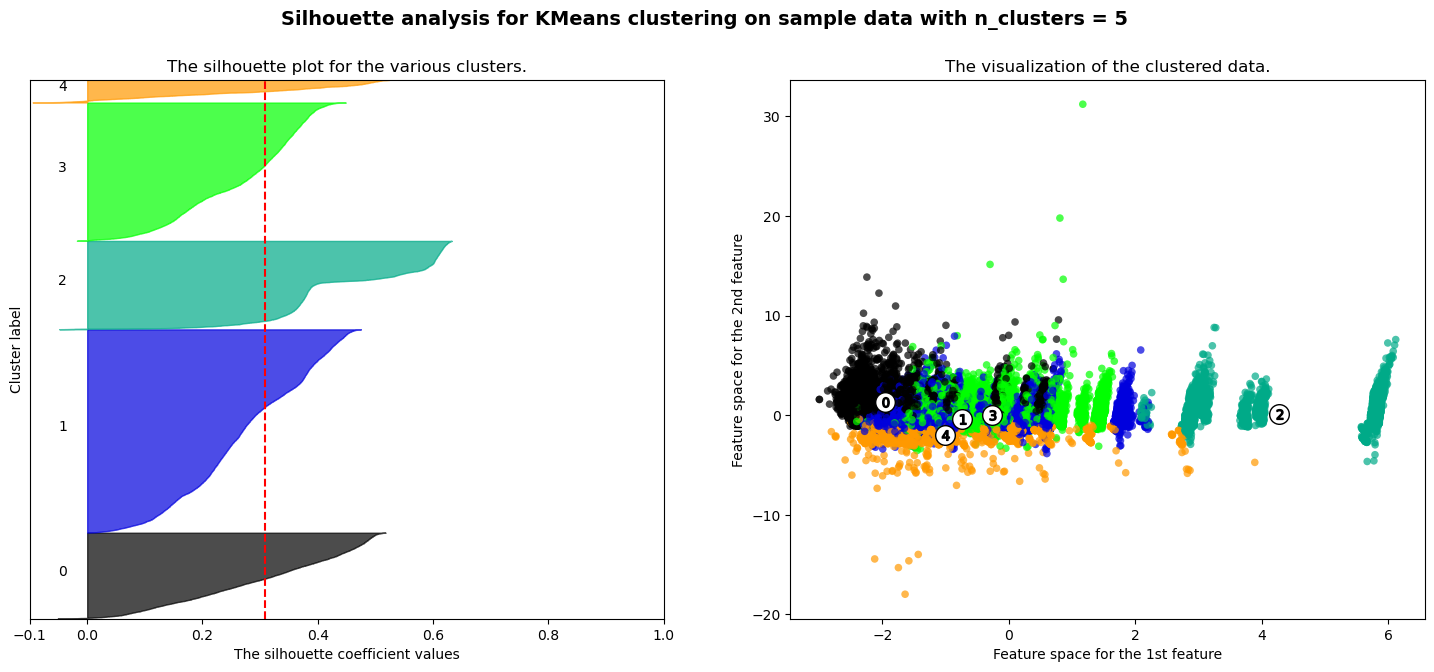

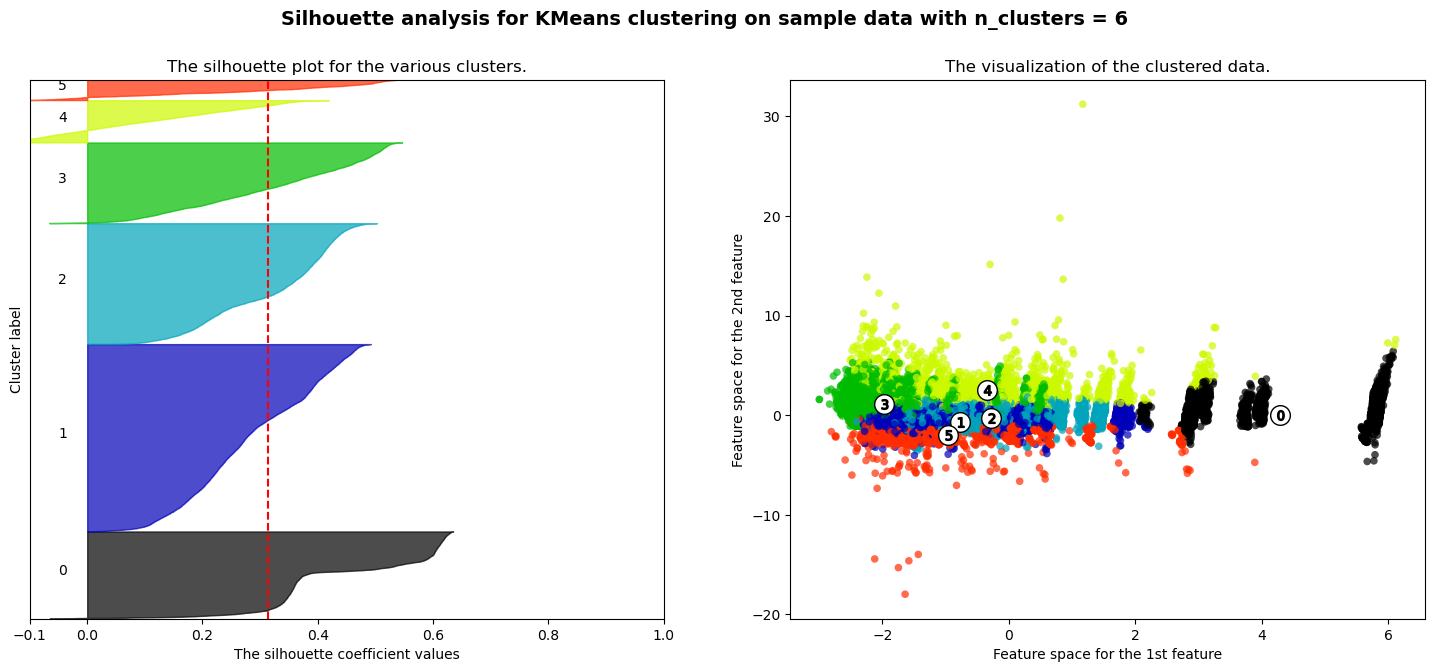

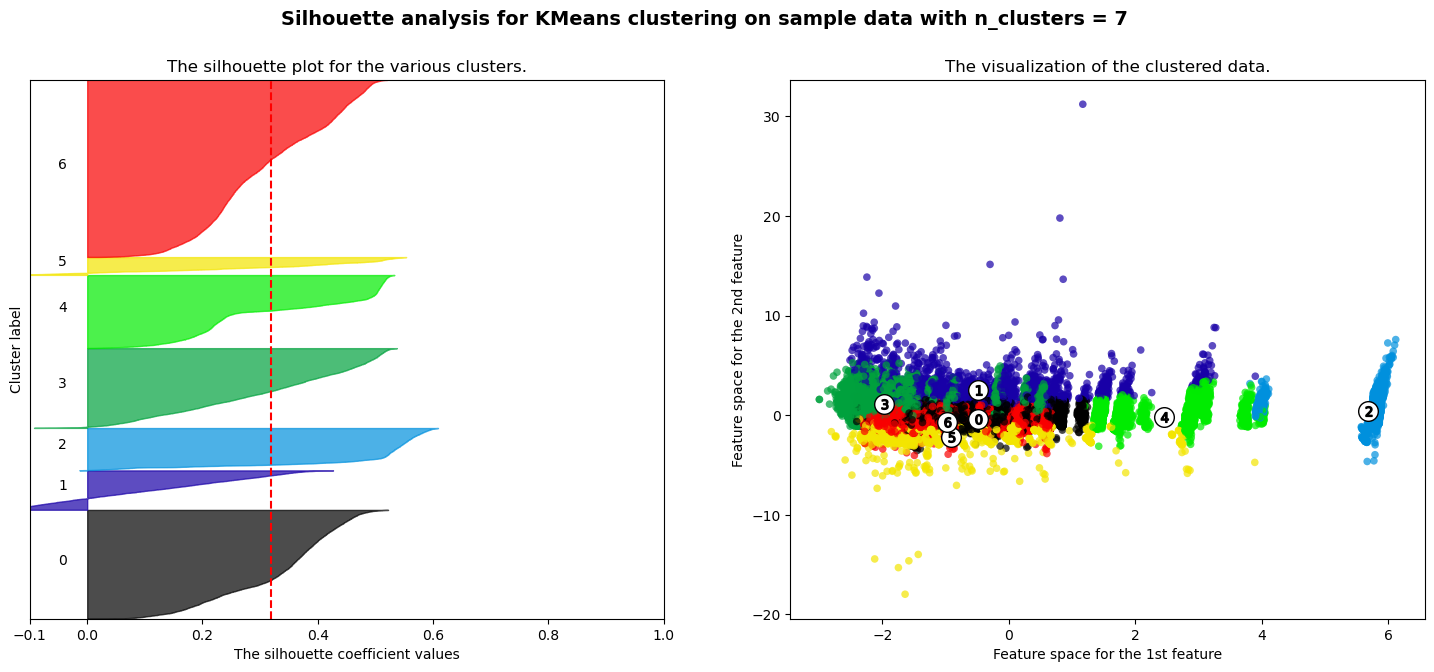

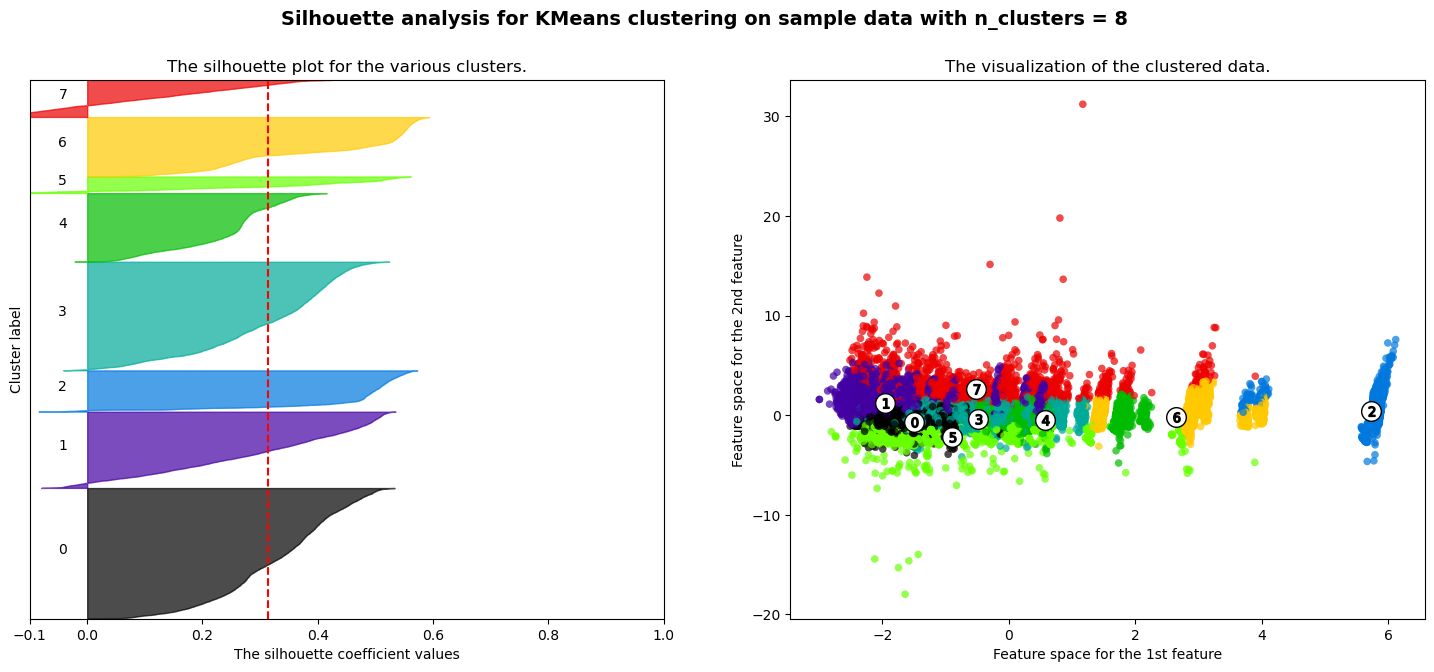

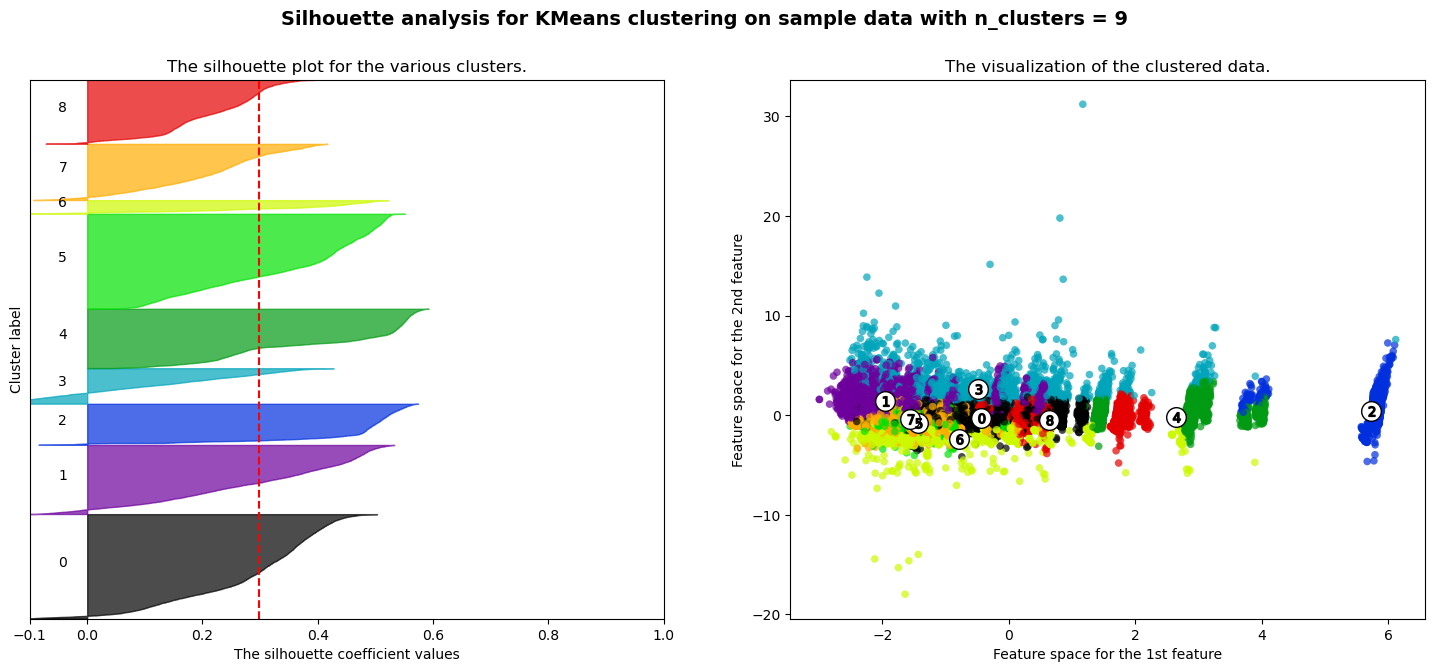

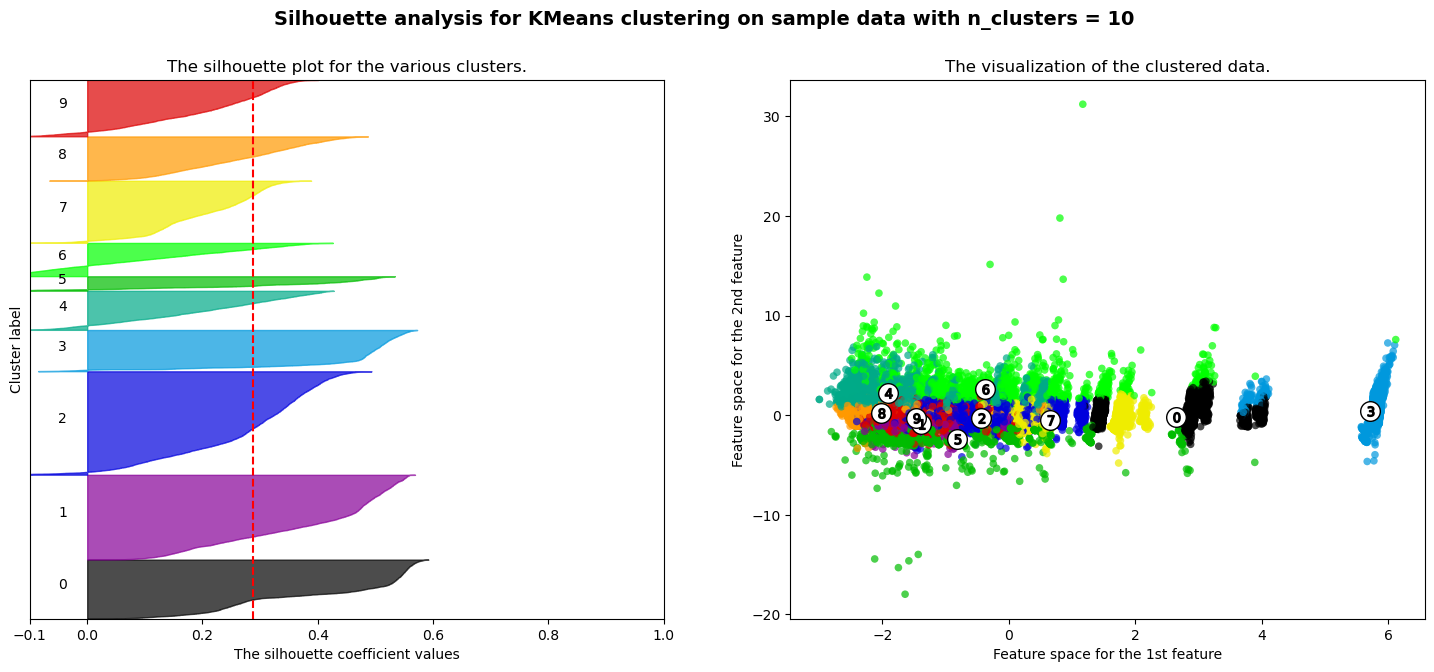

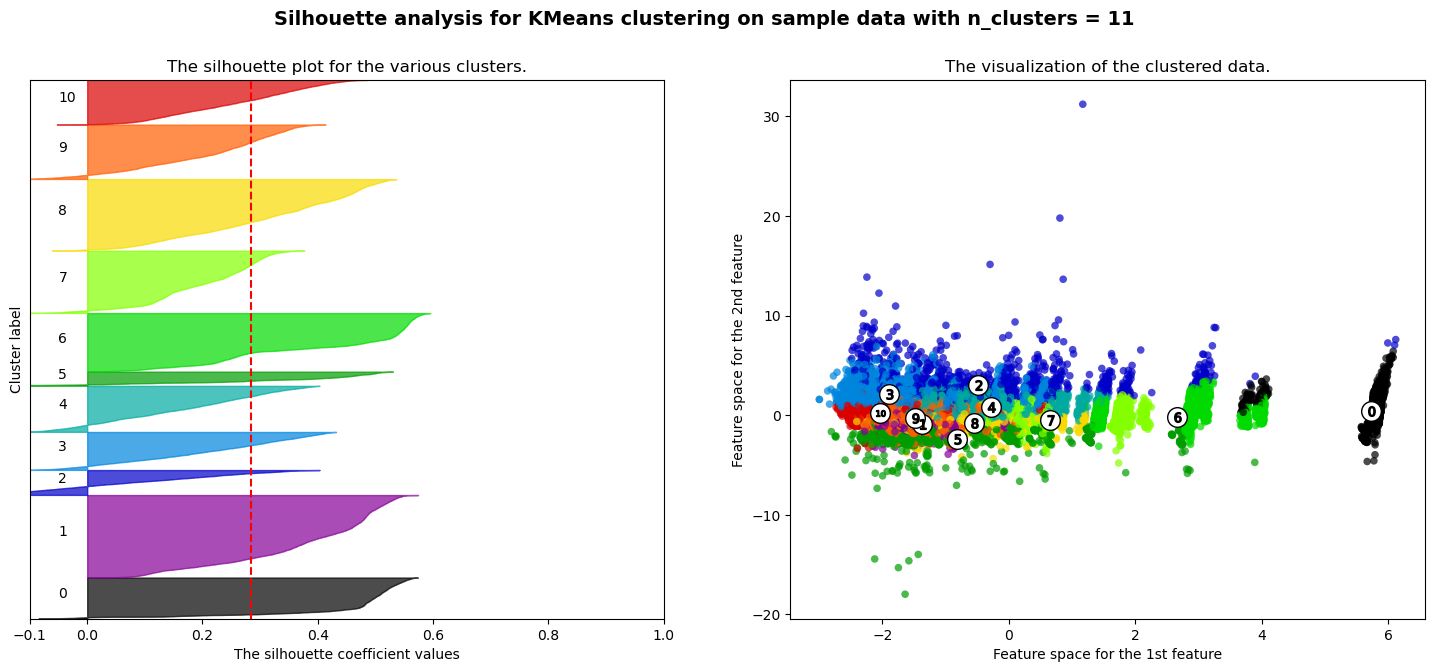

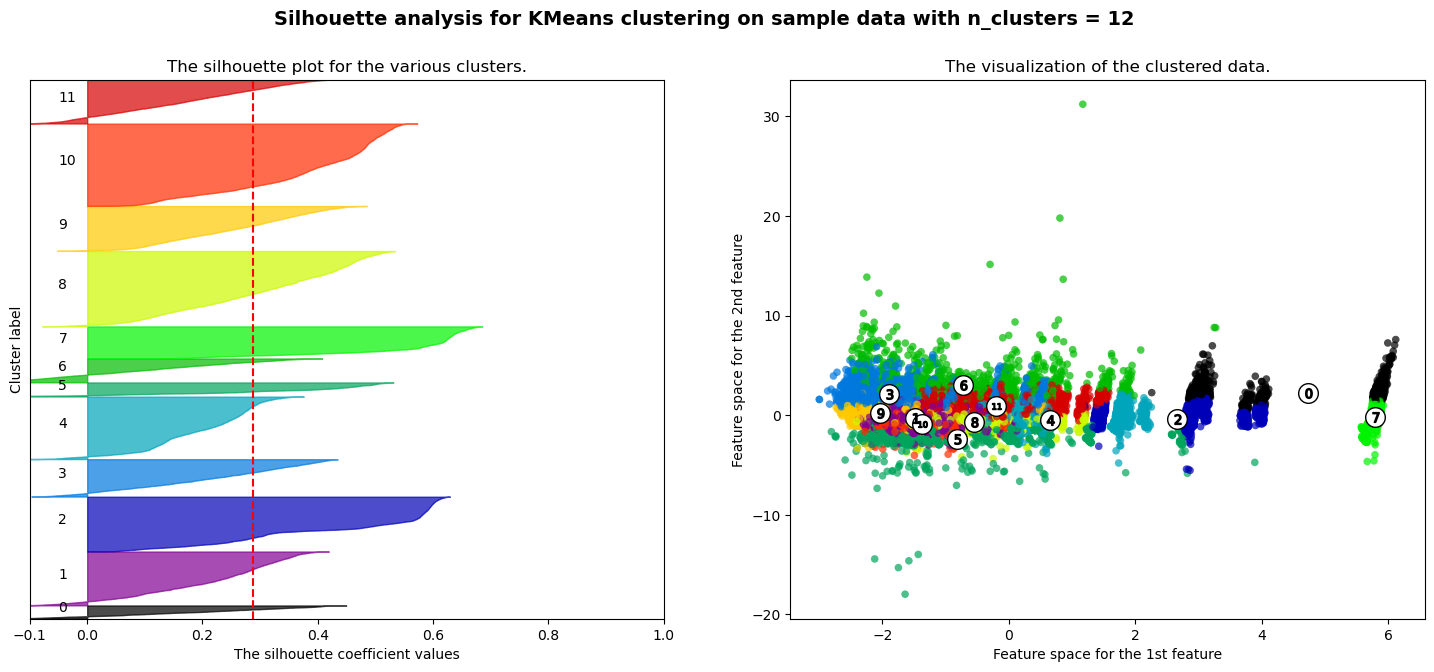

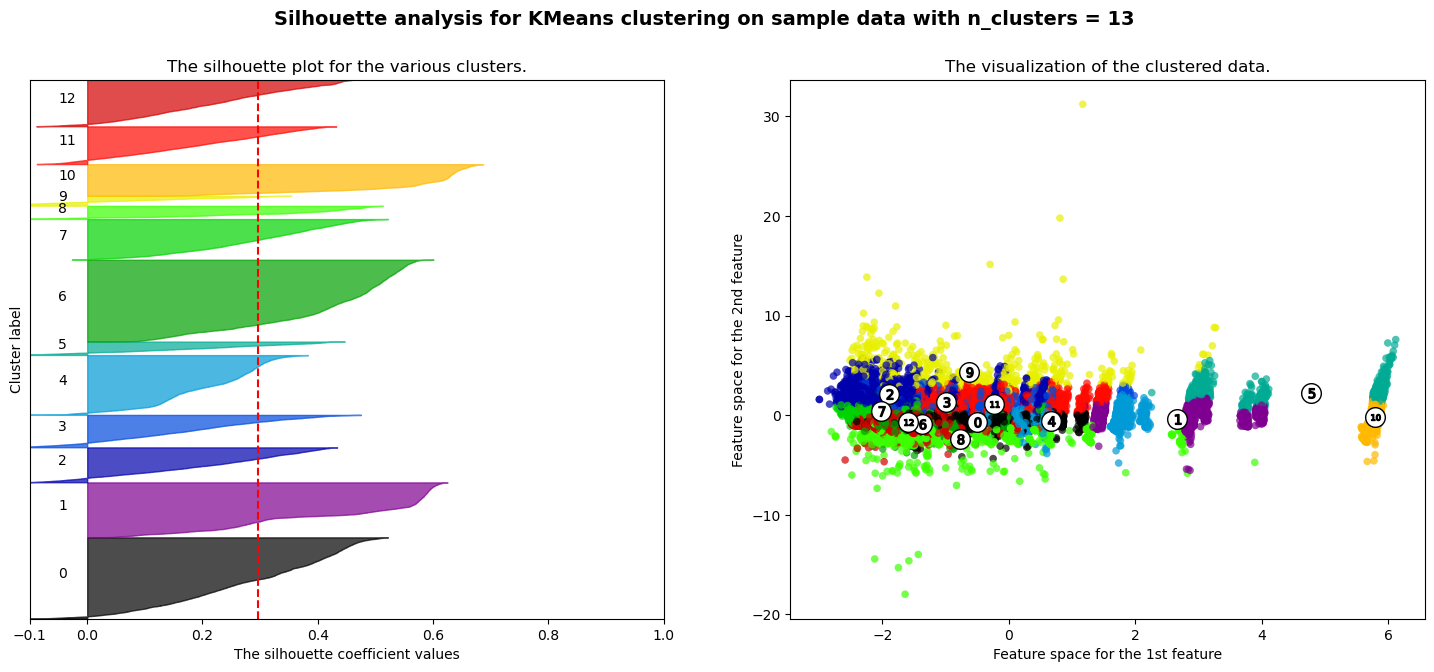

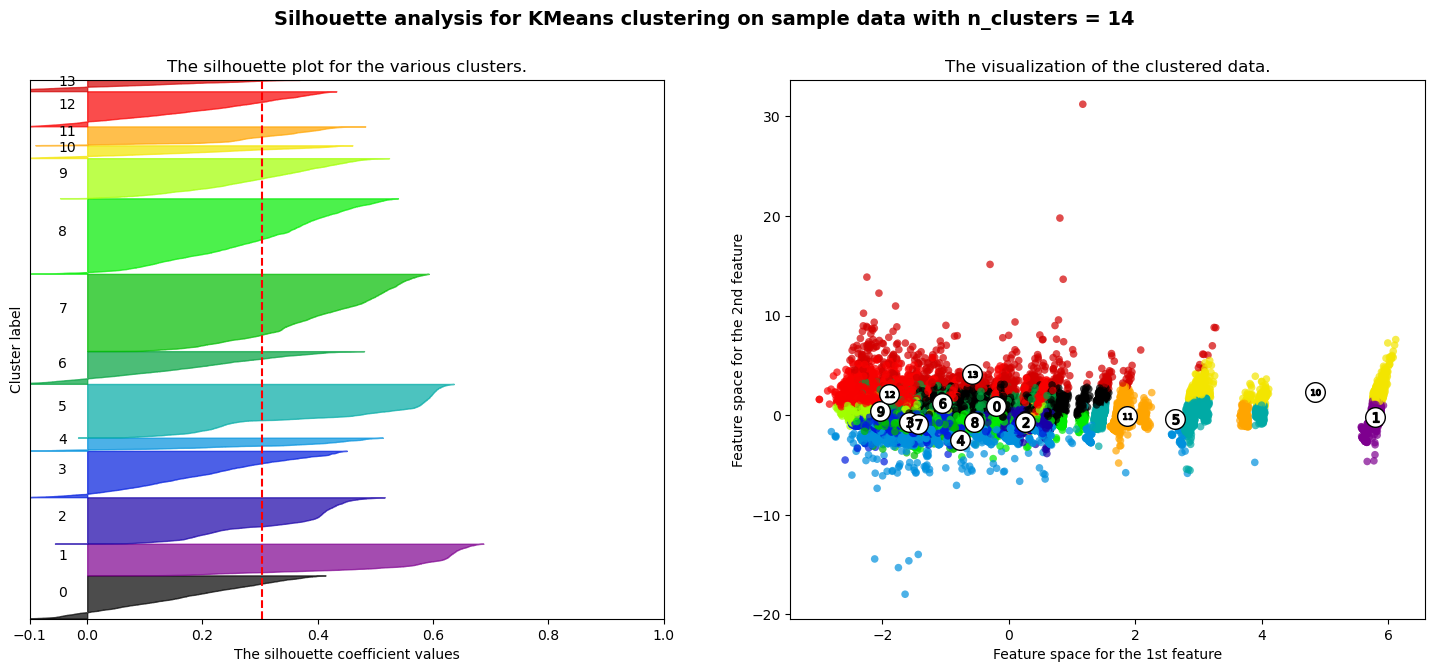

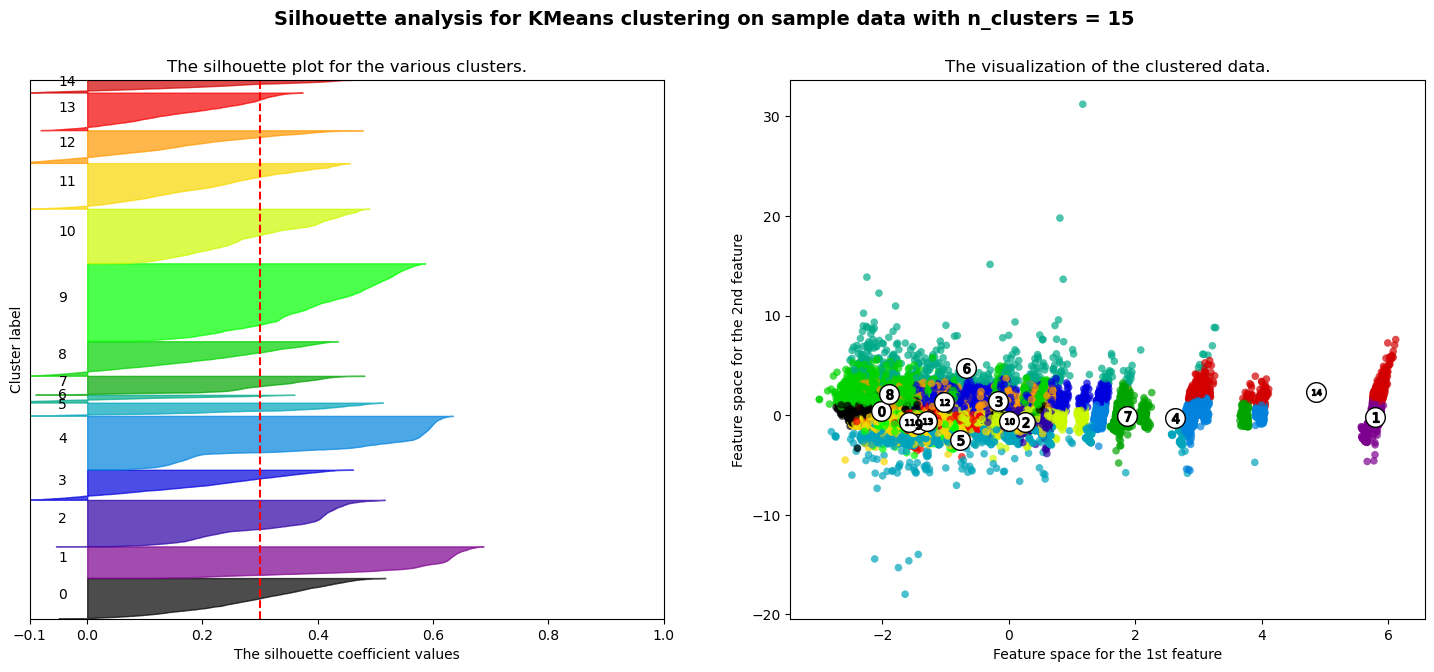

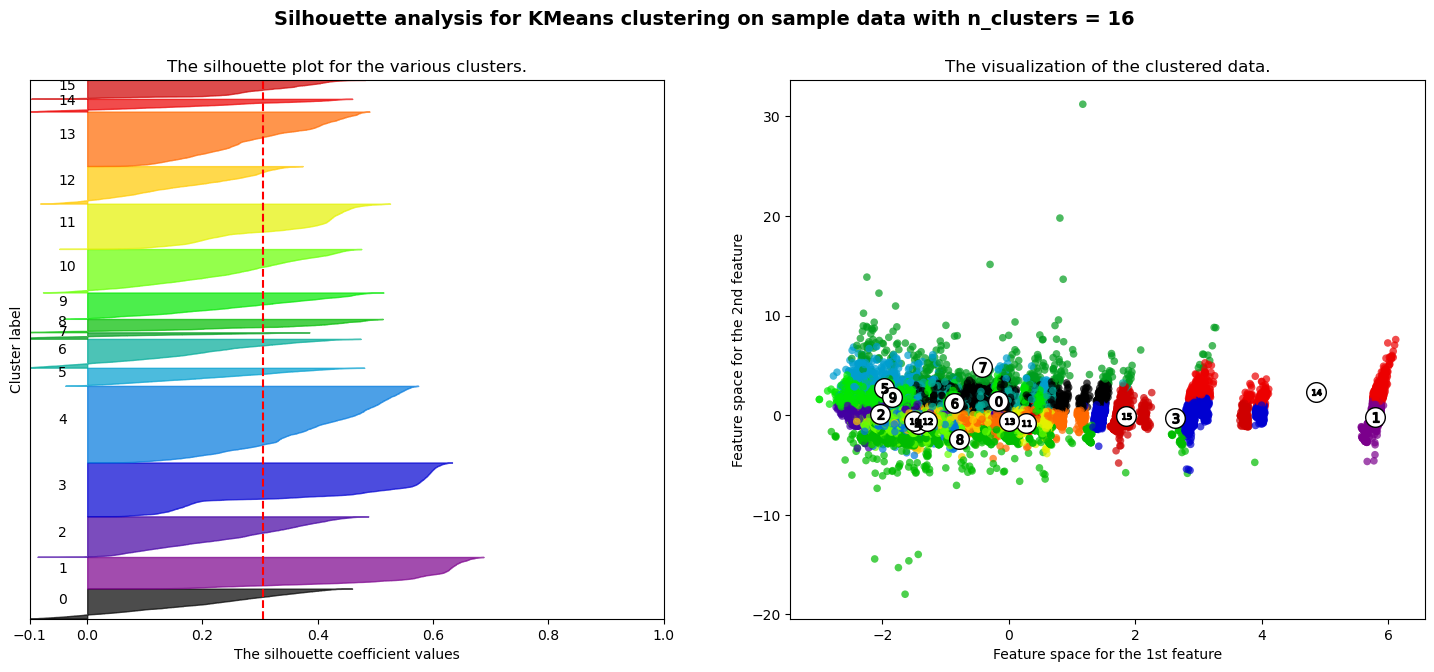

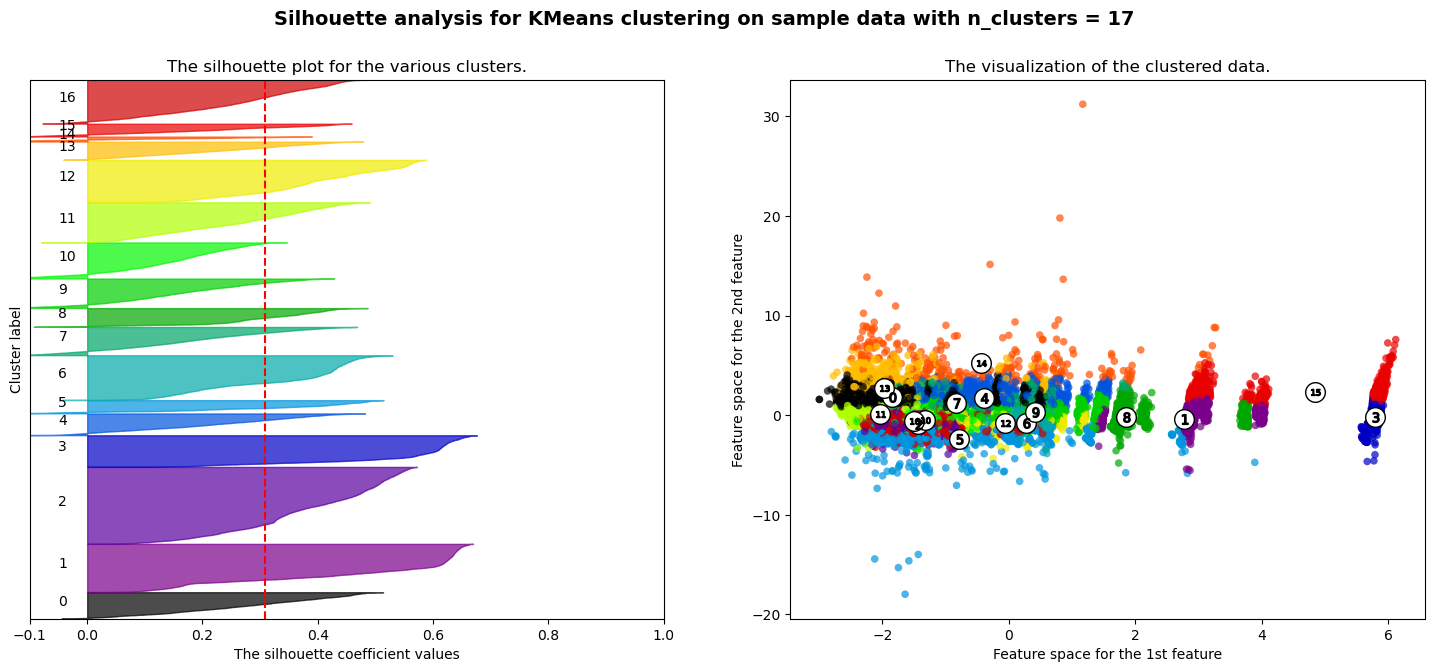

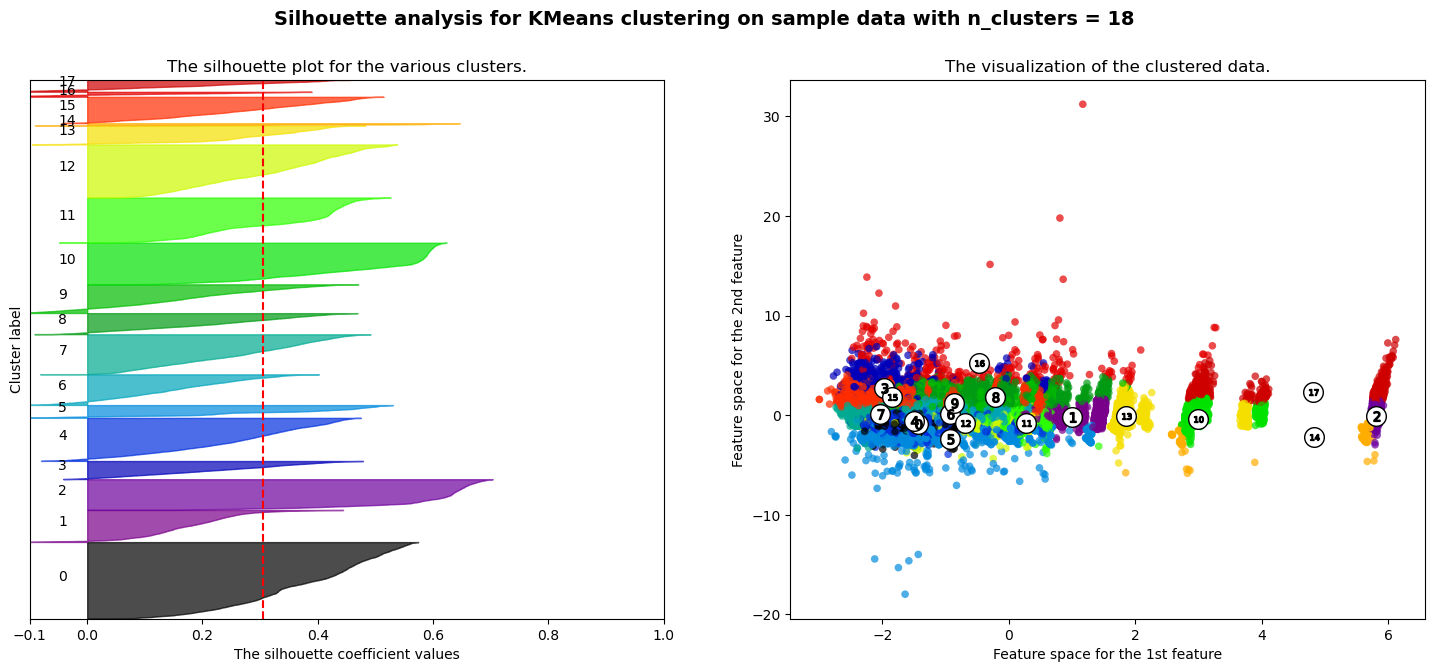

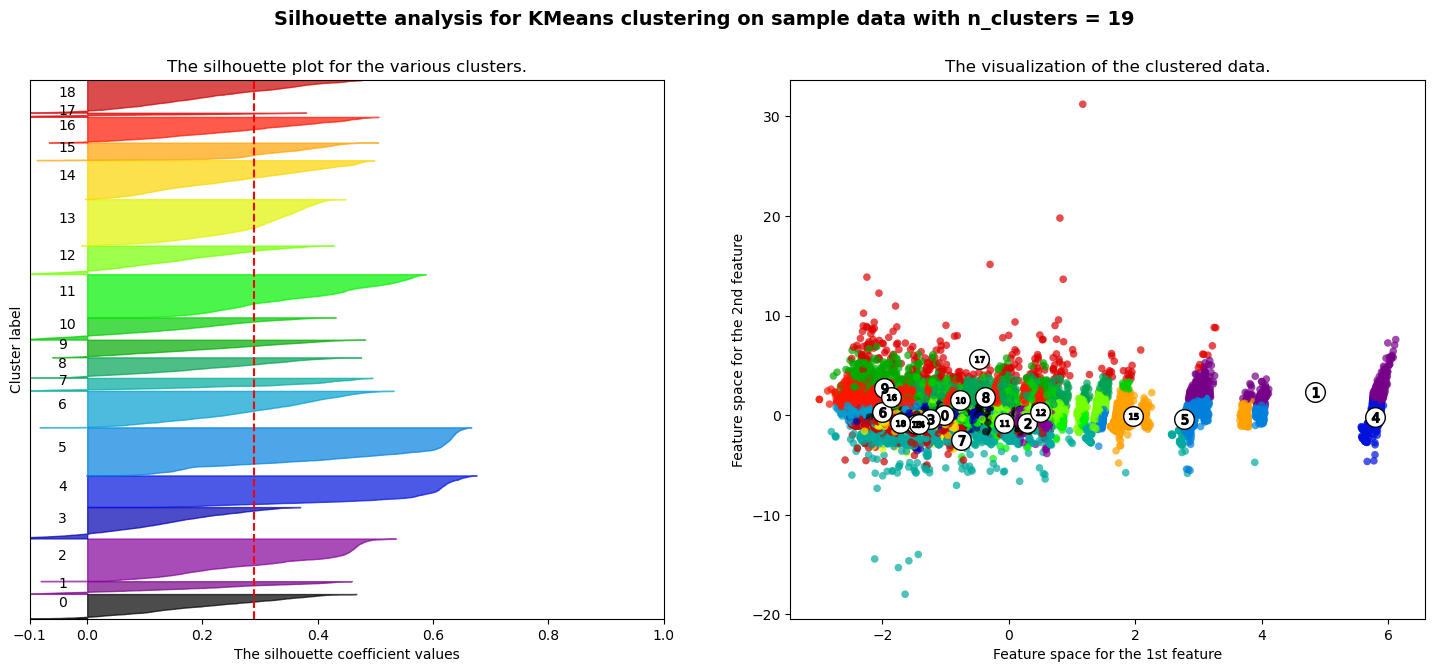

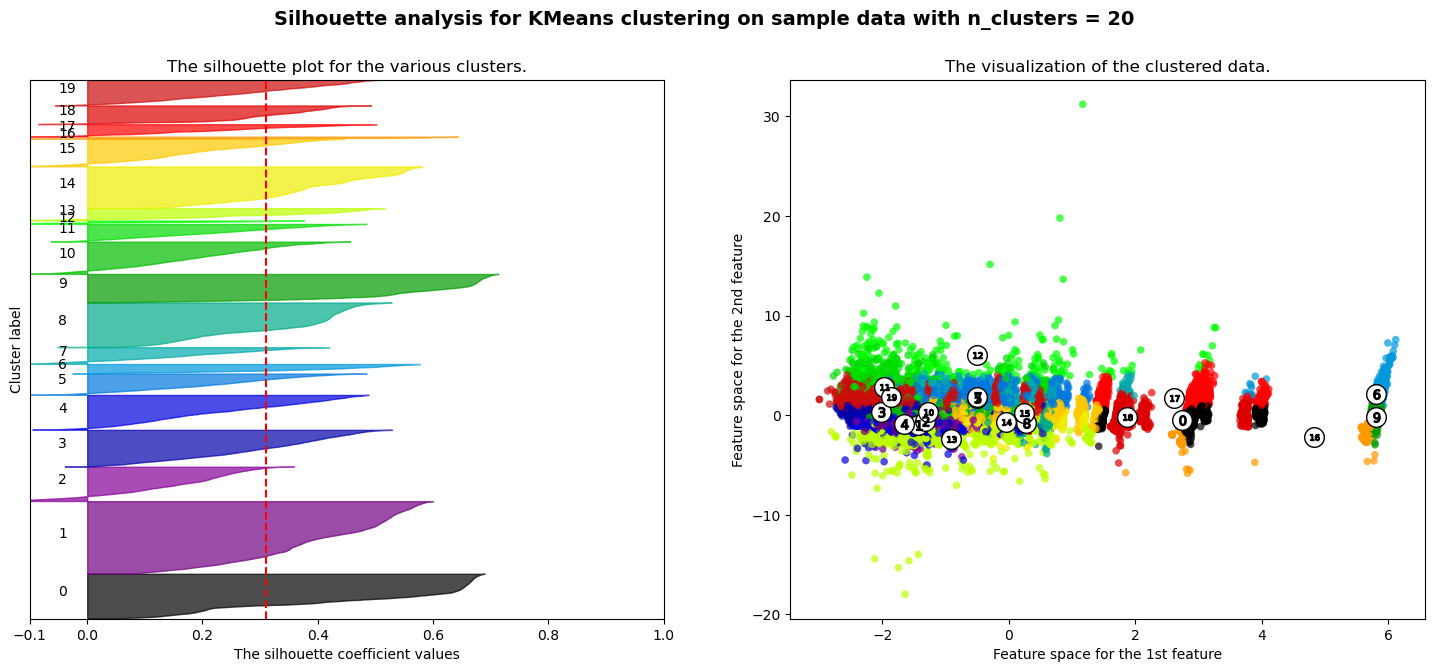

In [31]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
label_points = False
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    Xformed = pipe.named_steps.pca.fit_transform(pipe.named_steps.scale.fit_transform(airbnb_crime_X))
    ax1.set_ylim([0, len(Xformed) + (n_clusters + 1) * 10])

    pipe.named_steps.kmeans.set_params(n_clusters=n_clusters,random_state=42)
    clusterer = pipe.named_steps.kmeans
    cluster_labels = pipe.fit_predict(airbnb_crime_X)
    store_y_single = pd.concat([airbnb_crime_y, pd.Series(cluster_labels, name='cluster')], axis=1)
    stored_y[n_clusters] = store_y_single
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Xformed, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Xformed, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(Xformed[:, 0], Xformed[:, 1], marker='o', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    if label_points:
        for i,v in enumerate(Xformed):
            ax2.text(v[0],v[1],airbnb_crime_y.iloc[i][0],alpha=0.4)


    # Labeling the clusters
    centers = clusterer.cluster_centers_
    #print(centers)
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()

From the above results, we find that the n_clusters = 7 has the highest average silhouette_score. So we choose n_clusters = 7 as the number of clusters.

In [32]:
stored_y[7].head()

id  price  cluster
0   5121     60        2
1   5203     75        6
2   5136    275        0
3  29628     93        1
4   5586    295        6

In [33]:
airbnb_crime_with_cluster = pd.concat([airbnb_crime_X, stored_y[7]], axis=1)

In [34]:
airbnb_crime_with_cluster.head()

neighbourhood_group  latitude  longitude     room_type  minimum_nights  \
0            Brooklyn  40.68535  -73.95512  Private room              30   
1           Manhattan  40.80380  -73.96751  Private room               2   
2            Brooklyn  40.66265  -73.99454   Entire room              60   
3            Brooklyn  40.68292  -73.96381  Private room               3   
4           Manhattan  40.76076  -73.96156   Entire room               4   

   number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                 50               0.30                               2   
1                118               0.72                               1   
2                  3               0.03                               1   
3                350               2.25                               1   
4                 45               0.27                               1   

   availability_365  neighbourhood_cd  ...  annual_felony_rate  \
0               365             108.0  ...         2527.071429   
1                 0             126.0  ...          104.071429   
2               181             109.0  ...          395.857143   
3               145             107.0  ...          539.500000   
4                 1             142.0  ...           26.428571   

   annual_misdemeanor_rate  annual_violation_rate  annual_infraction_rate  \
0              4822.714286             628.000000               29.714286   
1               326.000000              32.714286                1.500000   
2               705.142857              94.214286                8.785714   
3               917.571429             116.142857                7.285714   
4               157.714286               3.428571                2.714286   

                        dominant_ofns dominant_perp_race price_category  \
0         marijuana, possession 4 & 5              black          0-100   
1         marijuana, possession 4 & 5              black          0-100   
2                           assault 3     white hispanic        201-300   
3  controlled substance, possession 7              black          0-100   
4         intoxicated driving,alcohol              white        201-300   

      id  price  cluster  
0   5121     60        2  
1   5203     75        6  
2   5136    275        0  
3  29628     93        1  
4   5586    295        6  

[5 rows x 21 columns]

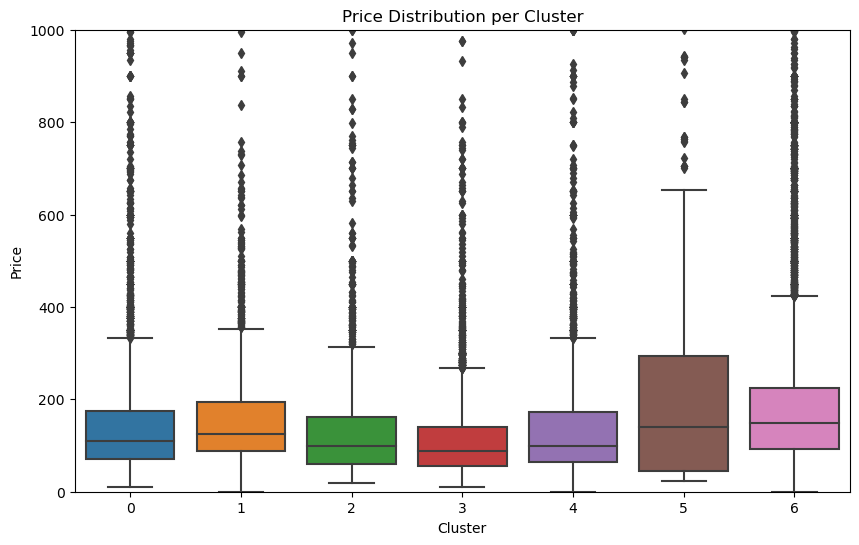

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=stored_y[7]['cluster'], y=stored_y[7]['price'])
plt.title('Price Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylim(0, 1000)
plt.ylabel('Price')
plt.show()

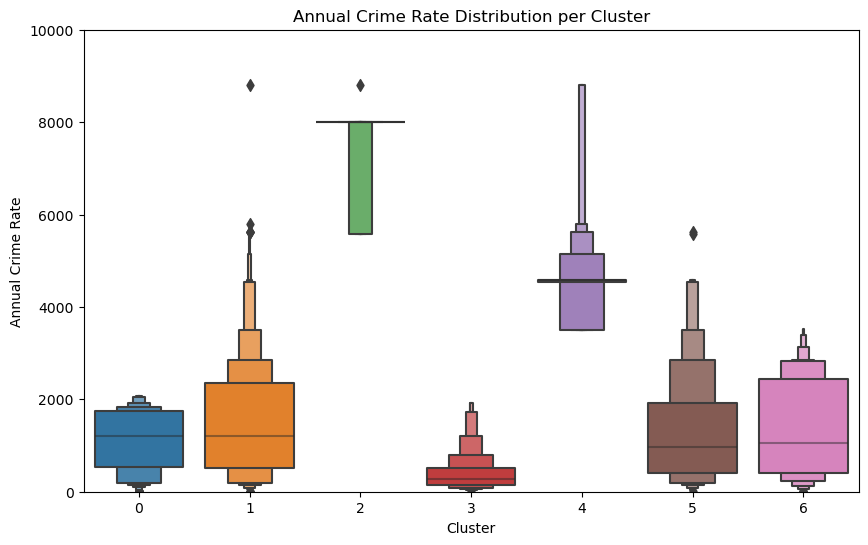

In [36]:
plt.figure(figsize=(10, 6))
sns.boxenplot(x=airbnb_crime_with_cluster['cluster'], y=airbnb_crime_with_cluster['annual_crime_rate'])
plt.title('Annual Crime Rate Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylim(0, 10000)
plt.ylabel('Annual Crime Rate')
plt.show()

From the above two boxplots, we cannot find the direct relationship between the clusters and the crime rate. For example, Cluster 2 has the highest crime rate while Cluster 3 has the lowest crimte rate, but there is no significant difference in prices between the two clusters. 

Now we attempt to visualize the clusters on the map. We first assign the neighborhood to the most frequent cluster in the neighborhood. Then we plot the clusters on the map.

In [37]:
neighborhood_cluster = airbnb_crime_with_cluster.groupby('neighbourhood_cd')['cluster'].agg(lambda x: x.mode()[0]).reset_index(name='most_common_cluster')

In [38]:
neighborhood_cluster['most_common_cluster'].value_counts()

3    145
0     98
6     90
4      7
1      5
2      2
Name: most_common_cluster, dtype: int64

In [39]:
neighborhood_cluster_list = neighborhood_cluster.groupby('most_common_cluster')['neighbourhood_cd'].apply(list)

In [40]:
neighborhood_cluster_list

most_common_cluster
0    [44.0, 45.0, 46.0, 47.0, 49.0, 50.0, 51.0, 52....
1                    [4.0, 301.0, 332.0, 336.0, 373.0]
2                                        [88.0, 108.0]
3    [28.0, 163.0, 164.0, 165.0, 166.0, 168.0, 169....
4           [8.0, 29.0, 41.0, 81.0, 89.0, 98.0, 154.0]
6    [0.0, 2.0, 3.0, 5.0, 6.0, 7.0, 9.0, 10.0, 11.0...
Name: neighbourhood_cd, dtype: object

In [44]:
class NYCDistrict:
    def __init__(self, dict):
        self.Coordinates = dict['geometry']['coordinates'][0][0]
        self.HolcGrade = dict['properties']['holc_grade']
        self.city = dict['properties']['city']
        self.name = dict['properties']['name']
        self.RandomLat = None
        self.RandomLong = None
        self.Median_Income = None
        self.CensusTract = None

    @property
    def HolcColor(self):
        if self.HolcGrade == 'A':
            return 'darkgreen'
        elif self.HolcGrade == 'B':
            return 'cornflowerblue'
        elif self.HolcGrade == 'C':
            return 'gold'
        elif self.HolcGrade == 'D':
            return 'maroon'
        else:
            return 'black'

all_geo = pd.read_json('./Data/fullDownload.geojson')
all_geo = all_geo['features']
def filter_ny(all):
    for i in range(len(all)):
        if all[i]['properties']['state'] != 'NY':
            del all[i]
        elif all[i]['properties']['city'] not in ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']:
            del all[i]
    return all

all_geo = filter_ny(all_geo)   

Districts = []
for district in all_geo:
    Districts.append(NYCDistrict(district))

In [42]:
from matplotlib.path import Path
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib  

Below is the geographical visualization of the clusters.

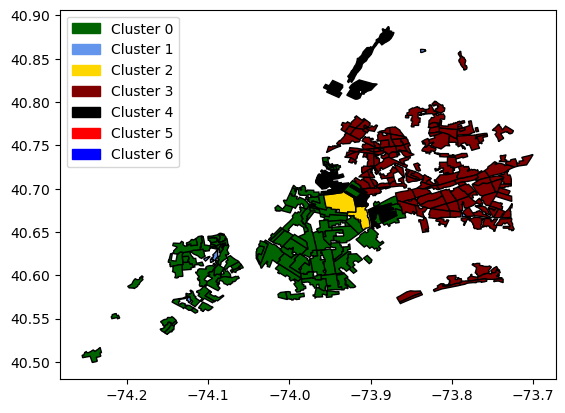

In [45]:
fig, ax = plt.subplots()    

colors = ['darkgreen', 'cornflowerblue', 'gold', 'maroon', 'black', 'red', 'blue']
labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6']


for i in range(len(neighborhood_cluster_list)): 
    try:
        for j in range(len(neighborhood_cluster_list[i])):
            ax.add_patch(matplotlib.patches.Polygon(Districts[int(neighborhood_cluster_list[i][j])].Coordinates, closed=True, fill=True, facecolor=colors[i], edgecolor='black'))
            ax.autoscale() 
            plt.rcParams["figure.figsize"] = (15,15)  
    except:
        continue
patch_list = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]
plt.legend(handles=patch_list, loc='upper left')
plt.show()

In [46]:
airbnb_crime_with_cluster = airbnb_crime_with_cluster.sort_values('price')
quantiles = airbnb_crime_with_cluster['price'].quantile([1/7, 2/7, 3/7, 4/7, 5/7, 6/7]).tolist()
bins = [-float('inf')] + quantiles + [float('inf')]
airbnb_crime_with_cluster['price_cluster'] = pd.cut(airbnb_crime_with_cluster['price'], bins=bins, labels=[0, 1, 2, 3, 4, 5, 6])
airbnb_crime_with_cluster.head()

neighbourhood_group  latitude  longitude   room_type  minimum_nights  \
17881           Manhattan  40.72186  -73.99278  Hotel room              30   
17860               Bronx  40.81513  -73.91602  Hotel room              30   
18289           Manhattan  40.72214  -73.98857  Hotel room               1   
17793           Manhattan  40.71610  -73.99518  Hotel room               1   
17573           Manhattan  40.76442  -73.96303  Hotel room               1   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
17881                  0               0.00                               1   
17860                  0               0.00                               1   
18289                 73               2.08                               1   
17793                348               8.05                               1   
17573                  5               0.15                               1   

       availability_365  neighbourhood_cd  ...  annual_misdemeanor_rate  \
17881                 0             147.0  ...               784.285714   
17860                 0              41.0  ...              6382.357143   
18289                 0             156.0  ...              1801.000000   
17793                 0             136.0  ...              1480.714286   
17573                 0             142.0  ...               157.714286   

       annual_violation_rate  annual_infraction_rate  \
17881             126.142857                3.857143   
17860             138.142857                5.357143   
18289             150.428571                8.142857   
17793             126.071429                4.857143   
17573               3.428571                2.714286   

                                dominant_ofns  dominant_perp_race  \
17881  ny state laws,unclassified misdemeanor               black   
17860                               assault 3               black   
18289             marijuana, possession 4 & 5      white hispanic   
17793                               assault 3               black   
17573             intoxicated driving,alcohol               white   

      price_category        id price  cluster  price_cluster  
17881            NaN  42228997     0        6              0  
17860            NaN  42065563     0        4              0  
18289            NaN  43078552     0        6              0  
17793            NaN  42279171     0        1              0  
17573            NaN  41740622     0        6              0  

[5 rows x 22 columns]

In [47]:
price_cluster = airbnb_crime_with_cluster.groupby('neighbourhood_cd')['price_cluster'].agg(lambda x: x.mode()[0]).reset_index(name='price_most_common_cluster')

In [48]:
price_cluster_list = price_cluster.groupby('price_most_common_cluster')['neighbourhood_cd'].apply(list)

Below is the geographical visualization of the clusters only based on the price.

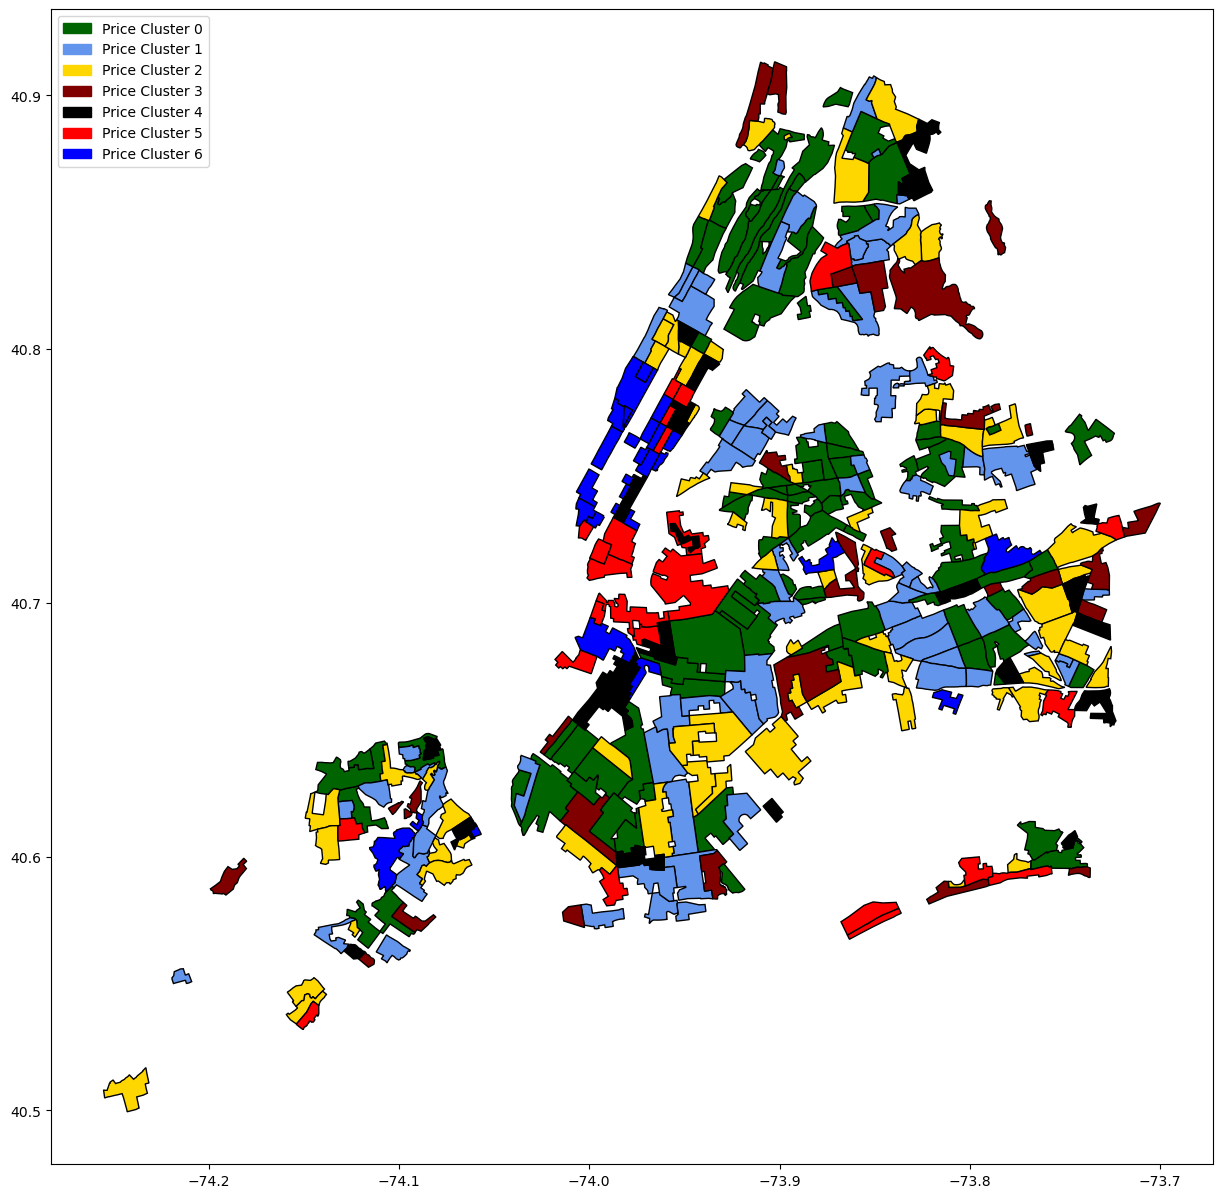

In [49]:
# price extent
fig, ax = plt.subplots()    

colors = ['darkgreen', 'cornflowerblue', 'gold', 'maroon', 'black', 'red', 'blue']
labels = ['Price Cluster 0', 'Price Cluster 1', 'Price Cluster 2', 'Price Cluster 3', 'Price Cluster 4', 'Price Cluster 5', 'Price Cluster 6']


for i in range(len(price_cluster_list)): 
    try:
        for j in range(len(price_cluster_list[i])):
            ax.add_patch(matplotlib.patches.Polygon(Districts[int(price_cluster_list[i][j])].Coordinates, closed=True, fill=True, facecolor=colors[i], edgecolor='black'))
            ax.autoscale() 
            plt.rcParams["figure.figsize"] = (15,15)  
    except:
        continue
patch_list = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]
plt.legend(handles=patch_list, loc='upper left')
plt.show()

Below is the geographical visualization of the clusters only based on dangerous extent obtained from the geojson file.

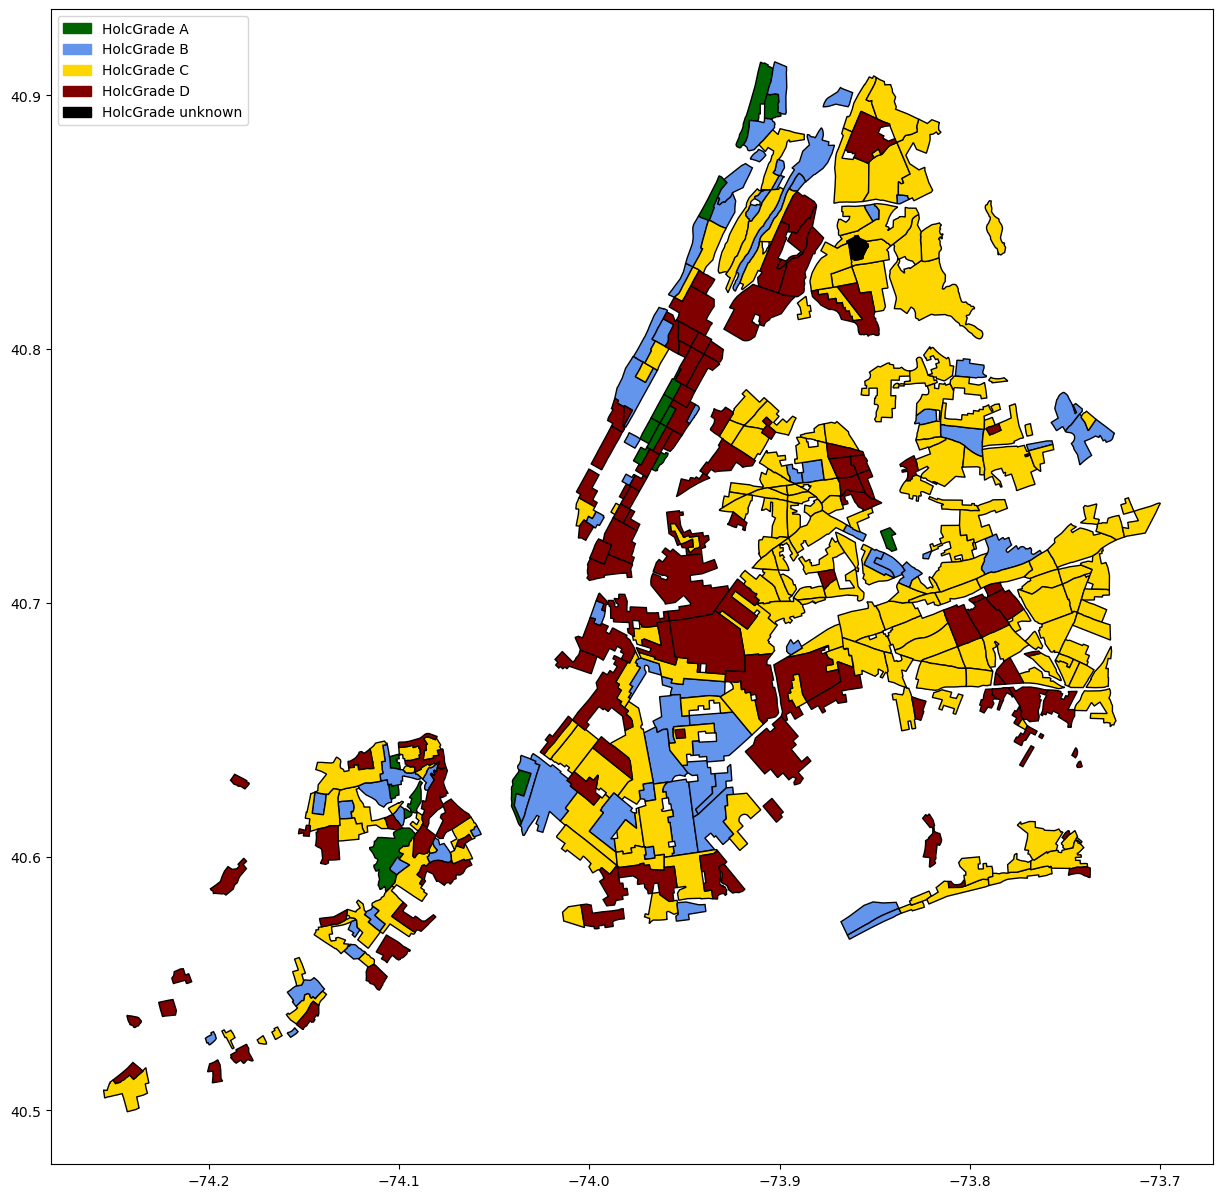

In [50]:
# dangerous extent
fig, ax = plt.subplots()    

colors = ['darkgreen', 'cornflowerblue', 'gold', 'maroon', 'black']
labels = ['HolcGrade A', 'HolcGrade B', 'HolcGrade C', 'HolcGrade D', 'HolcGrade unknown']

for i in range(len(Districts)): 
    ax.add_patch(matplotlib.patches.Polygon(Districts[i].Coordinates, closed=True, fill=True, facecolor=Districts[i].HolcColor, edgecolor='black'))
    ax.autoscale() 
    plt.rcParams["figure.figsize"] = (15,15)  

patch_list = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]
plt.legend(handles=patch_list, loc='upper left')
plt.show()

Compared to the previous geographical plot according to the dangerous extent, we find the clusters obtained by K-means clustering are determined by the region of the city, not so associated with the discrete distribution of the crime rate.

Thus, we can conclude that the crime rate is not the toppest main factor affecting the price of airbnb. Other factors may count more.